王の作ったコード


In [4]:
from urllib import request 
import logging
from pathlib import Path
import numpy as np
import re
# import MeCab
import random
from gensim import corpora, models
import pandas as pd
from tqdm import tqdm

# データ読み込み

2015年からのデータを辞書に使う(ちょうど5年分だし安定しているので)


In [6]:
ls_data = !ls data/article2

In [68]:
df = pd.DataFrame()
df_len = []
n = 47
for ll in ls_data[n:n+12]:
    print(ll)
    df_buf =  pd.read_csv('data/article2/' + ll)
    df_len.append(len(df_buf))
    df = pd.concat([df, df_buf], axis = 0,  ignore_index=True)

2014-12-31 000000-content.csv
2015-01-31 000000-content.csv
2015-02-28 000000-content.csv
2015-03-31 000000-content.csv
2015-04-30 000000-content.csv
2015-05-31 000000-content.csv
2015-06-30 000000-content.csv
2015-07-31 000000-content.csv
2015-08-31 000000-content.csv
2015-09-30 000000-content.csv
2015-10-31 000000-content.csv
2015-11-30 000000-content.csv


In [63]:
# 欠損値の数と割合を求める
def missingval_table(df):
    mv_df = pd.DataFrame(df.isnull().sum())
    mv_df = mv_df.rename(columns={0:'null count'})
    mv_df['null count(%)'] = mv_df['null count']/len(df)*100
    mv_df['variation'] = df.nunique().values
    mv_df['variation(%)'] = df.nunique().values/len(df)*100
    return mv_df

missingval_table(df)

,null count,null count(%),variation,variation(%)
Unnamed: 0,0,0.000000,8492,15.843284
id,0,0.000000,53600,100.000000
article_id,0,0.000000,53600,100.000000
title,0,0.000000,53544,99.895522
created_at,0,0.000000,53501,99.815299
likes_count,0,0.000000,760,1.417910
tags_str,0,0.000000,27094,50.548507
url,0,0.000000,53600,100.000000
tokens,3,0.005597,53200,99.253731


In [70]:
df_len

[3694, 3792, 3846, 3638, 3989, 3946, 4283, 4056, 3953, 4236, 4501, 8492]

In [71]:
df['tokens'] = df['tokens'].replace(np.nan, "", regex=True)

## 辞書を作成する

In [155]:
import unicodedata

def normalize(text):
    normalized_text = normalize_unicode(text)
    normalized_text = lower_text(normalized_text)
    return normalized_text


def lower_text(text):
    return text.lower()


def normalize_unicode(text, form='NFKC'):
    normalized_text = unicodedata.normalize(form, text)
    return normalized_text

In [156]:
def make_dict(year):
    df = pd.DataFrame()
    df_len = []
    for ll in ls_data:
        if ll.find(str(year)):
            continue
        print(ll)
        df_buf =  pd.read_csv('data/article2/' + ll)
        df_len.append(len(df_buf))
        df = pd.concat([df, df_buf], axis = 0,  ignore_index=True)

    df['tokens'] = df['tokens'].replace(np.nan, "", regex=True)
    print(df_len)
    share_list = []
    for sh in df["tokens"]:
        sh_no = normalize(sh)
    #     print(share)
        if type(sh_no) is str:        
            share_list.append([s for s in sh_no.split(" ") if len(s) > 1])
        else:
            share_list.append([])

    d = corpora.Dictionary(share_list)
    print("num pos : " + str(d.num_pos))
    d.save("data/dictionary/dict{}.dict".format(year))
    return d

    
        

In [157]:
for i in range(2014, 2019):
    make_dict(i)

2014-01-31 000000-content.csv
2014-02-28 000000-content.csv
2014-03-31 000000-content.csv
2014-04-30 000000-content.csv
2014-05-31 000000-content.csv
2014-06-30 000000-content.csv
2014-07-31 000000-content.csv
2014-08-31 000000-content.csv
2014-09-30 000000-content.csv
2014-10-31 000000-content.csv
2014-11-30 000000-content.csv
2014-12-31 000000-content.csv
[2253, 2516, 2792, 2948, 3155, 3321, 3070, 3164, 3161, 3239, 5411, 3694]
num pos : 7588124
2015-01-31 000000-content.csv
2015-02-28 000000-content.csv
2015-03-31 000000-content.csv
2015-04-30 000000-content.csv
2015-05-31 000000-content.csv
2015-06-30 000000-content.csv
2015-07-31 000000-content.csv
2015-08-31 000000-content.csv
2015-09-30 000000-content.csv
2015-10-31 000000-content.csv
2015-11-30 000000-content.csv
2015-12-31 000000-content.csv
[3792, 3846, 3638, 3989, 3946, 4283, 4056, 3953, 4236, 4501, 8492, 4868]
num pos : 12332760
2016-01-31 000000-content.csv
2016-02-29 0000

In [158]:
ls_dict = !ls data/dictionary

In [159]:
d_all = corpora.Dictionary()
for di in ls_dict:
    d = corpora.Dictionary.load("data/dictionary/" + di)
    d.filter_extremes(no_below=5, no_above=0.2)
    d.compactify()
    print(len(d))
    d_all.merge_with(d)
    print("d_all: " + str(len(d_all)))
d_all.compactify()
print(len(d_all))

d_all.save("data/dictionary_test/dict2014_2018.dict")

31305
d_all: 31305
42210
d_all: 44881
51109
d_all: 57178
55064
d_all: 66394
68408
d_all: 80216
80216


In [160]:
d_one = corpora.Dictionary.load("data/dictionary/dict2018.dict")
d_one.filter_extremes(no_below=5, no_above=0.2)
d_one.save("data/dictionary_test/dict2018.dict")

In [137]:
# d_all2 = corpora.Dictionary()
# for di in ls_dict:
#     d = corpora.Dictionary.load("data/dictionary/" + di)
#     d_all2.merge_with(d)
#     print("d_all: " + str(len(d_all2)))
    
# d_all2.filter_extremes(no_below=5, no_above=0.2)
# d_all2.compactify()
# print(len(d_all2))

d_all: 235725
d_all: 429645
d_all: 609786
d_all: 838971
d_all: 1049083
100000


分かち書き後の処理
・1文字なものを削除
・すべて小文字に変更



データベースから一年分のデータを読み込む

In [26]:
# d.filter_extremes(no_below=5, no_above=0.2)
# # nob_below以下の個数の単語を無視
# # no_aboveの割合以上に出てくる単語を無視
# d.compactify()
# # idを振り直してコンパクトにする。

# 確認

In [143]:
d = d_all

In [146]:
print(len(d))
print(d[1289])
print("python id:",d.token2id["python"])
print("C++ id:",d.token2id["c++"])
print(d.doc2bow(["探索","ノード"]))

88229
手動
python id: 299
C++ id: 1348
[(6804, 1), (8178, 1)]


In [147]:
dic_num = len(d)
dic_num

88229

In [148]:
d[0]

'issue'

In [149]:
[(d[t[0]],t[1])for t in sorted(d.dfs.items(),key=lambda x:x[1],reverse=True)]

[('コマンド', 71048),
 ('あっ', 70412),
 ('問題', 70090),
 ('たり', 69760),
 ('情報', 69435),
 ('自分', 69416),
 ('なかっ', 69050),
 ('機能', 68226),
 ('より', 67901),
 ('可能', 67797),
 ('実装', 65556),
 ('内容', 64664),
 ('取得', 64176),
 ('かも', 63772),
 ('エラー', 63530),
 ('みる', 63523),
 ('対応', 63000),
 ('とか', 62917),
 ('作っ', 62670),
 ('良い', 62618),
 ('でし', 62514),
 ('上記', 62295),
 ('すれ', 62052),
 ('使い', 61777),
 ('やっ', 61430),
 ('あれ', 60702),
 ('起動', 59796),
 ('実際', 59311),
 ('以上', 59271),
 ('部分', 59111),
 ('どう', 59021),
 ('はじめ', 58954),
 ('ましょ', 56869),
 ('入力', 56587),
 ('思っ', 55593),
 ('られ', 54810),
 ('だっ', 54517),
 ('開発', 54483),
 ('いき', 54324),
 ('説明', 54178),
 ('によって', 54092),
 ('状態', 53952),
 ('でも', 53740),
 ('参照', 53369),
 ('よく', 53330),
 ('簡単', 53260),
 ('動作', 53078),
 ('けど', 52806),
 ('定義', 52770),
 ('画面', 52762),
 ('下記', 52355),
 ('選択', 52259),
 ('行う', 51996),
 ('こんな', 51795),
 ('せる', 51730),
 ('てる', 51563),
 ('こちら', 51489),
 ('データ', 51414),
 ('通り', 51261),
 ('アクセス', 51243),
 ('出力', 51154),
 ('のみ', 510

# コーパスを作成する

# bow


In [30]:
# corpus = [d.doc2bow(w) for w in docs]
# test_size = int(len(corpus) * 0.1)
# test_corpus = corpus[:test_size]
# train_corpus= corpus[test_size:]
# print("test size: ", len(test_corpus))
# print("train size: ", len(train_corpus))

In [161]:
def make_bow_corpus(year, d):
    df = pd.DataFrame()
    df_len = []
    for ll in ls_data:
        if ll.find(str(year)):
            continue
        print(ll)
        df_buf =  pd.read_csv('data/article2/' + ll)
        df_len.append(len(df_buf))
        df = pd.concat([df, df_buf], axis = 0,  ignore_index=True)

    df['tokens'] = df['tokens'].replace(np.nan, "", regex=True)
    print(df_len)
    share_list = []
    for sh in df["tokens"]:
        sh_no = normalize(sh)
    #     print(share)
        if type(sh_no) is str:        
            share_list.append([s for s in sh_no.split(" ") if len(s) > 1])
        else:
            share_list.append([])
    corpus = [d.doc2bow(w) for w in share_list]
    return corpus

In [162]:
corpus_5years = make_bow_corpus(2019, d_all)
corpora.MmCorpus.serialize("data/corpus/bow_copus_from_dict2014-2018.mm", corpus_5years)

2019-01-31 000000-content.csv
2019-02-28 000000-content.csv
2019-03-31 000000-content.csv
2019-04-30 000000-content.csv
2019-05-31 000000-content.csv
2019-06-30 000000-content.csv
2019-07-31 000000-content.csv
2019-08-31 000000-content.csv
2019-09-30 000000-content.csv
2019-10-31 000000-content.csv
2019-11-30 000000-content.csv
[8225, 9322, 9481, 10056, 9899, 9762, 9508, 9839, 10453, 10656, 63]


In [163]:
corpus_oneyear = make_bow_corpus(2019, d_one)
corpora.MmCorpus.serialize("data/corpus/bow_copus_from_dict2018.mm", corpus_oneyear)

2019-01-31 000000-content.csv
2019-02-28 000000-content.csv
2019-03-31 000000-content.csv
2019-04-30 000000-content.csv
2019-05-31 000000-content.csv
2019-06-30 000000-content.csv
2019-07-31 000000-content.csv
2019-08-31 000000-content.csv
2019-09-30 000000-content.csv
2019-10-31 000000-content.csv
2019-11-30 000000-content.csv
[8225, 9322, 9481, 10056, 9899, 9762, 9508, 9839, 10453, 10656, 63]


# tfidf

In [166]:
# tfidf
import gensim
tfidf = gensim.models.TfidfModel(corpus_5years)
tfidf.save('corpus/model_5years.tfidf')

# make corpus_tfidf
corpus_tfidf = tfidf[corpus_5years]

# save corpus_tfidf
with open("corpus/corpus_tfidf.pkl",'w') as f:
    pickle.dump(corpus_tfidf,f)

FileNotFoundError: [Errno 2] No such file or directory: 'corpus/model_5years.tfidf'

In [31]:
corpus = [d.doc2bow(w) for w in share_list]
test_size = int(len(corpus) * 0.1)
test_corpus = corpus[:test_size]
train_corpus= corpus[test_size:]
print("test size: ", len(test_corpus))
print("train size: ", len(train_corpus))

test size:  8384
train size:  75458


In [ ]:
corpus

In [172]:
# corpus = [d.doc2bow(w) for w in share_list]
test_size = int(len(corpus_5years) * 0.1)
test_corpus = corpus_5years[:test_size]
train_corpus= corpus_5years[test_size:]
print("test size: ", len(test_corpus))
print("train size: ", len(train_corpus))

test size:  9726
train size:  87538


# LDAの学習

In [167]:
lda5 = models.ldamodel.LdaModel(corpus=corpus_5years, id2word=d_all, num_topics=50, passes=10)

In [168]:
logging.basicConfig(format='%(message)s', level=logging.INFO)

In [33]:
lda = models.ldamodel.LdaModel(corpus=corpus, id2word=d, num_topics=50, passes=10)

using symmetric alpha at 0.02
using symmetric eta at 0.02
using serial LDA version on this node
running online (multi-pass) LDA training, 50 topics, 10 passes over the supplied corpus of 83842 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
PROGRESS: pass 0, at document #2000/83842
merging changes from 2000 documents into a model of 83842 documents
topic #7 (0.020): 0.004*"問題" + 0.004*"データ" + 0.004*"ディレクトリ" + 0.004*"実装" + 0.004*"コマンド" + 0.004*"移動" + 0.003*"情報" + 0.003*"計算" + 0.003*"プログラム" + 0.003*"オプション"
topic #33 (0.020): 0.007*"関数" + 0.005*"バージョン" + 0.005*"情報" + 0.005*"実装" + 0.005*"起動" + 0.004*"削除" + 0.004*"データ" + 0.004*"状態" + 0.004*"選択" + 0.004*"コマンド"
topic #18 (0.020): 0.009*"データ" + 0.005*"問題" + 0.004*"機能" + 0.004*"ユーザー" + 0.004*"値" + 0.004*"関数" + 0.004*"プログラム" + 0.004*"エラー" + 0.004*"投稿" + 0.004*"実装"
topic #12 (0.020): 0.007*"関数" + 0.006*"ライブラリ" + 0.005*"イベント" + 0.005*"wine" + 0

topic #44 (0.020): 0.026*"API" + 0.024*"取得" + 0.024*"サーバー" + 0.024*"接続" + 0.018*"認証" + 0.018*"サーバ" + 0.018*"アクセス" + 0.014*"client" + 0.013*"通信" + 0.013*"ドメイン"
topic #0 (0.020): 0.015*"開発" + 0.015*"テスト" + 0.010*"プロジェクト" + 0.009*"spring" + 0.009*"java" + 0.008*"XML" + 0.007*"データ" + 0.007*"機能" + 0.007*"アノテーション" + 0.007*"ライブラリ"
topic #36 (0.020): 0.035*"起動" + 0.032*"コマンド" + 0.012*"接続" + 0.010*"OS" + 0.010*"ポート" + 0.009*"プロセス" + 0.009*"SSH" + 0.008*"ホスト" + 0.008*"構築" + 0.008*"windows"
topic #3 (0.020): 0.065*"関数" + 0.050*"データ" + 0.026*"python" + 0.016*"出力" + 0.013*"学習" + 0.010*"計算" + 0.010*"実装" + 0.008*"入力" + 0.008*"リスト" + 0.007*"Neural Network"
topic diff=0.485683, rho=0.333333
-11.235 per-word bound, 2409.9 perplexity estimate based on a held-out corpus of 2000 documents with 322224 words
PROGRESS: pass 0, at document #20000/83842
merging changes from 2000 documents into a model of 83842 documents
topic #45 (0.020): 0.032*"関数" + 0.015*"オブジェクト" + 0.014*"ゲーム" + 0.013*"状態" + 0.009*"メソッド" + 0

topic #41 (0.020): 0.024*"トランザクション" + 0.024*"ブロック" + 0.021*"wg" + 0.021*"Blockchain" + 0.021*"suite" + 0.011*"Bitcoin" + 0.010*"取引" + 0.009*"入手可能" + 0.008*"ノード" + 0.008*"FOUNDATION"
topic diff=0.240852, rho=0.242536
PROGRESS: pass 0, at document #36000/83842
merging changes from 2000 documents into a model of 83842 documents
topic #26 (0.020): 0.048*"選択" + 0.044*"クリック" + 0.038*"画面" + 0.030*"入力" + 0.030*"ボタン" + 0.015*"アカウント" + 0.014*"押す" + 0.014*"開く" + 0.014*"項目" + 0.013*"登録"
topic #22 (0.020): 0.071*"PHP" + 0.025*"接続" + 0.019*"Raspberry Pi" + 0.016*"USB" + 0.011*"電源" + 0.011*"LED" + 0.011*"ラズパイ" + 0.010*"温度" + 0.009*"センサー" + 0.009*"Arduino"
topic #21 (0.020): 0.067*"git" + 0.045*"GitHub" + 0.038*"リポジトリ" + 0.030*"ブランチ" + 0.028*"コミット" + 0.021*"セル" + 0.019*"PUSH" + 0.017*"firebase" + 0.014*"ローカル" + 0.013*"管理"
topic #31 (0.020): 0.027*"送信" + 0.021*"メール" + 0.019*"メッセージ" + 0.018*"通知" + 0.017*"SLACK" + 0.016*"送る" + 0.012*"取得" + 0.011*"シート" + 0.010*"受信" + 0.010*"宛先"
topic #33 (0.020): 0.030*"鍵

topic #1 (0.020): 0.043*"Re・Act" + 0.020*"データ" + 0.020*"native" + 0.012*"component" + 0.012*"state" + 0.011*"トレーニング" + 0.011*"予測" + 0.011*"train" + 0.011*"feature" + 0.010*"machine learning"
topic #19 (0.020): 0.026*"IMAGE" + 0.019*"input" + 0.012*"max" + 0.012*"説明" + 0.012*"行動" + 0.011*"方策" + 0.011*"価値" + 0.011*"size" + 0.011*"フレーム" + 0.011*"報酬"
topic #25 (0.020): 0.056*"list" + 0.031*"compile" + 0.025*"G+" + 0.024*"cpp" + 0.023*"STD" + 0.023*"ROS" + 0.022*"Code" + 0.020*"template" + 0.017*"conda" + 0.015*"断片"
topic diff=0.122460, rho=0.196116
PROGRESS: pass 0, at document #54000/83842
merging changes from 2000 documents into a model of 83842 documents
topic #11 (0.020): 0.054*"データ" + 0.049*"テーブル" + 0.030*"db" + 0.029*"データベース" + 0.022*"SQL" + 0.020*"id" + 0.017*"モデル" + 0.016*"MySQL" + 0.015*"削除" + 0.015*"カラム"
topic #42 (0.020): 0.030*"サービス" + 0.018*"システム" + 0.015*"管理" + 0.014*"可能" + 0.013*"機能" + 0.012*"データ" + 0.012*"提供" + 0.011*"リソース" + 0.009*"AZURE" + 0.008*"アプリケーション"
topic #3 (0.020

topic diff=0.079038, rho=0.171499
PROGRESS: pass 0, at document #70000/83842
merging changes from 2000 documents into a model of 83842 documents
topic #11 (0.020): 0.051*"データ" + 0.050*"テーブル" + 0.034*"データベース" + 0.033*"db" + 0.024*"SQL" + 0.019*"MySQL" + 0.018*"id" + 0.018*"モデル" + 0.017*"削除" + 0.016*"カラム"
topic #33 (0.020): 0.038*"鍵" + 0.030*"RUBY" + 0.028*"動画" + 0.026*"公開鍵" + 0.025*"暗号" + 0.025*"SSH" + 0.024*"生成" + 0.024*"署名" + 0.023*"秘密鍵" + 0.019*"暗号化"
topic #7 (0.020): 0.016*"AI" + 0.016*"座標" + 0.011*"描画" + 0.011*"ロボット" + 0.010*"位置" + 0.010*"回転" + 0.008*"移動" + 0.007*"頂点" + 0.007*"方向" + 0.006*"人間"
topic #30 (0.020): 0.039*"API" + 0.031*"ページ" + 0.031*"URL" + 0.023*"リクエスト" + 0.020*"web" + 0.018*"HTML" + 0.015*"Android標準ブラウザ" + 0.014*"JSON" + 0.012*"サイト" + 0.012*"POST"
topic #45 (0.020): 0.027*"状態" + 0.015*"オブジェクト" + 0.014*"関数" + 0.010*"実装" + 0.010*"持つ" + 0.009*"ゲーム" + 0.008*"考える" + 0.007*"パターン" + 0.006*"依存" + 0.006*"オブジェクト指向"
topic diff=0.071722, rho=0.169031
PROGRESS: pass 0, at documen

topic #41 (0.020): 0.057*"ノード" + 0.055*"ブロック" + 0.022*"トランザクション" + 0.018*"ロック" + 0.016*"コントラクト" + 0.015*"Blockchain" + 0.013*"攻撃" + 0.011*"取引" + 0.010*"ネットワーク" + 0.009*"反射"
topic #13 (0.020): 0.041*"出力" + 0.038*"コマンド" + 0.025*"オプション" + 0.013*"標準" + 0.013*"形式" + 0.013*"スクリプト" + 0.011*"ディレクトリ" + 0.010*"ファイル名" + 0.010*"CSV" + 0.009*"ツール"
topic #47 (0.020): 0.034*"flutter" + 0.028*"Xcode" + 0.025*"swift" + 0.020*"命令" + 0.018*"ボード" + 0.018*"ESP" + 0.015*"ST" + 0.014*"レジスタ" + 0.011*"割り込み" + 0.010*"dart"
topic #2 (0.020): 0.026*"データ" + 0.019*"グラフ" + 0.012*"モデル" + 0.012*"予測" + 0.011*"特徴" + 0.011*"用いる" + 0.011*"計算" + 0.010*"パラメータ" + 0.010*"ベクトル" + 0.010*"分布"
topic diff=0.057490, rho=0.150891
PROGRESS: pass 1, at document #4000/83842
merging changes from 2000 documents into a model of 83842 documents
topic #38 (0.020): 0.034*"バージョン" + 0.033*"python" + 0.029*"パッケージ" + 0.029*"ダウンロード" + 0.018*"ビルド" + 0.016*"Folder" + 0.015*"ライブラリ" + 0.015*"windows" + 0.011*"ディレクトリ" + 0.011*"パス"
topic #6 (0.020): 0.

topic #32 (0.020): 0.037*"NOT FOUND" + 0.029*"mod" + 0.027*"ABC" + 0.026*"Scala" + 0.019*"golang" + 0.018*"記号" + 0.018*"時刻" + 0.016*"ショートカットキー" + 0.015*"system" + 0.015*"TEX"
topic diff=0.044881, rho=0.150891
-11.173 per-word bound, 2309.6 perplexity estimate based on a held-out corpus of 2000 documents with 322224 words
PROGRESS: pass 1, at document #20000/83842
merging changes from 2000 documents into a model of 83842 documents
topic #26 (0.020): 0.064*"選択" + 0.057*"クリック" + 0.054*"画面" + 0.040*"ボタン" + 0.038*"入力" + 0.021*"押す" + 0.017*"開く" + 0.015*"登録" + 0.014*"メニュー" + 0.012*"完了"
topic #33 (0.020): 0.042*"鍵" + 0.032*"RUBY" + 0.031*"key" + 0.031*"動画" + 0.027*"公開鍵" + 0.027*"秘密鍵" + 0.025*"生成" + 0.025*"SSH" + 0.022*"署名" + 0.022*"暗号"
topic #38 (0.020): 0.033*"バージョン" + 0.031*"ダウンロード" + 0.031*"python" + 0.030*"パッケージ" + 0.019*"ビルド" + 0.017*"Folder" + 0.016*"windows" + 0.015*"ライブラリ" + 0.011*"ディレクトリ" + 0.011*"パス"
topic #5 (0.020): 0.057*"TO" + 0.039*"AND" + 0.033*"IS" + 0.017*"ON" + 0.015*"YOU" +

topic #29 (0.020): 0.061*"計算" + 0.022*"求める" + 0.020*"frac" + 0.016*"行列" + 0.014*"関数" + 0.013*"theta" + 0.012*"問題" + 0.011*"RM" + 0.011*"PI" + 0.011*"定義"
topic #34 (0.020): 0.027*"文字" + 0.027*"文字列" + 0.019*"変換" + 0.016*"値" + 0.014*"数値" + 0.013*"要素" + 0.013*"数字" + 0.012*"リスト" + 0.011*"単語" + 0.010*"入力"
topic #30 (0.020): 0.045*"API" + 0.036*"URL" + 0.033*"ページ" + 0.023*"リクエスト" + 0.018*"web" + 0.018*"JSON" + 0.016*"HTML" + 0.015*"サイト" + 0.014*"Android標準ブラウザ" + 0.012*"取得"
topic #2 (0.020): 0.022*"データ" + 0.015*"グラフ" + 0.015*"特徴" + 0.013*"予測" + 0.012*"用いる" + 0.012*"アルゴリズム" + 0.011*"平均" + 0.010*"確率" + 0.010*"モデル" + 0.010*"ベクトル"
topic diff=0.052128, rho=0.150891
PROGRESS: pass 1, at document #38000/83842
merging changes from 2000 documents into a model of 83842 documents
topic #45 (0.020): 0.027*"状態" + 0.017*"実装" + 0.013*"持つ" + 0.010*"考える" + 0.009*"依存" + 0.008*"パターン" + 0.007*"関数" + 0.007*"オペランド" + 0.007*"設計" + 0.007*"呼ぶ"
topic #34 (0.020): 0.028*"文字" + 0.027*"文字列" + 0.019*"変換" + 0.015*"値" + 0.01

topic #22 (0.020): 0.034*"接続" + 0.022*"USB" + 0.021*"デバイス" + 0.020*"Raspberry Pi" + 0.015*"Arduino" + 0.014*"LED" + 0.014*"電源" + 0.013*"ラズパイ" + 0.013*"PC" + 0.012*"センサー"
topic diff=0.040255, rho=0.150891
PROGRESS: pass 1, at document #54000/83842
merging changes from 2000 documents into a model of 83842 documents
topic #12 (0.020): 0.062*"モジュール" + 0.053*"UNITY" + 0.036*"オブジェクト" + 0.026*"カメラ" + 0.023*"ゲーム" + 0.022*"配置" + 0.020*"スクリプト" + 0.018*"シーン" + 0.017*"3D" + 0.014*"インポート"
topic #46 (0.020): 0.070*"インスタンス" + 0.048*"ログ" + 0.030*"EC2" + 0.030*"グループ" + 0.029*"タスク" + 0.023*"IP" + 0.017*"VPC" + 0.017*"ルール" + 0.016*"タイプ" + 0.016*"デフォルト"
topic #27 (0.020): 0.042*"メソッド" + 0.041*"クラス" + 0.031*"関数" + 0.027*"変数" + 0.026*"引数" + 0.025*"定義" + 0.022*"値" + 0.020*"オブジェクト" + 0.017*"型" + 0.014*"配列"
topic #31 (0.020): 0.039*"送信" + 0.036*"メッセージ" + 0.027*"メール" + 0.024*"通知" + 0.021*"SLACK" + 0.018*"送る" + 0.016*"bot" + 0.013*"受信" + 0.013*"LINE" + 0.012*"音声"
topic #48 (0.020): 0.010*"読む" + 0.010*"勉強" + 0.00

topic #19 (0.020): 0.046*"()" + 0.021*"input" + 0.016*"text" + 0.015*"フレーム" + 0.015*"IMAGE" + 0.013*"size" + 0.012*"TRUE" + 0.012*"max" + 0.010*"filter" + 0.010*"array"
topic #0 (0.020): 0.028*"開発" + 0.015*"チーム" + 0.011*"java" + 0.010*"プロジェクト" + 0.008*"ツール" + 0.008*"システム" + 0.008*"spring" + 0.008*"改善" + 0.007*"組織" + 0.007*"メンバー"
topic #10 (0.020): 0.036*"イベント" + 0.028*"実装" + 0.018*"プロセス" + 0.014*"THREAD" + 0.013*"()" + 0.013*"関数" + 0.013*"終了" + 0.012*"非同期" + 0.012*"ストリーム" + 0.012*"状態"
topic diff=0.030315, rho=0.150891
PROGRESS: pass 1, at document #72000/83842
merging changes from 2000 documents into a model of 83842 documents
topic #41 (0.020): 0.098*"ノード" + 0.052*"ブロック" + 0.023*"Blockchain" + 0.023*"トランザクション" + 0.021*"ロック" + 0.011*"ネットワーク" + 0.011*"攻撃" + 0.010*"transaction" + 0.009*"取引" + 0.009*"コントラクト"
topic #13 (0.020): 0.047*"コマンド" + 0.040*"出力" + 0.025*"オプション" + 0.016*"スクリプト" + 0.015*"標準" + 0.014*"形式" + 0.014*"ディレクトリ" + 0.013*"変換" + 0.011*"ファイル名" + 0.010*"ツール"
topic #6 (0.020): 0.

topic diff=0.032881, rho=0.149202
PROGRESS: pass 2, at document #4000/83842
merging changes from 2000 documents into a model of 83842 documents
topic #17 (0.020): 0.207*"PHP" + 0.066*"laravel" + 0.024*"composer" + 0.016*"エンティティ" + 0.015*"DI" + 0.013*"n/" + 0.013*"echo" + 0.011*"spark" + 0.011*"名前空間" + 0.011*"cd"
topic #4 (0.020): 0.238*"画像" + 0.070*"プロパティ" + 0.032*"フォント" + 0.026*"生成" + 0.018*"サイズ" + 0.016*"写真" + 0.015*"保存" + 0.015*"GENERATOR" + 0.013*"PNG" + 0.012*"ピクセル"
topic #36 (0.020): 0.048*"起動" + 0.032*"コマンド" + 0.020*"接続" + 0.017*"Linux" + 0.017*"OS" + 0.014*"windows" + 0.013*"SSH" + 0.012*"Ubuntu" + 0.010*"CentOS" + 0.010*"再起動"
topic #32 (0.020): 0.031*"Scala" + 0.028*"mod" + 0.025*"ABC" + 0.019*"system" + 0.019*"A3" + 0.018*"golang" + 0.018*"レジストリ" + 0.016*"Unicode" + 0.015*"JA" + 0.014*"ND"
topic #0 (0.020): 0.029*"開発" + 0.017*"チーム" + 0.012*"プロジェクト" + 0.011*"spring" + 0.009*"java" + 0.008*"システム" + 0.008*"メンバー" + 0.007*"ツール" + 0.007*"改善" + 0.007*"設計"
topic diff=0.030239, rho=0.

topic #38 (0.020): 0.033*"バージョン" + 0.032*"python" + 0.032*"パッケージ" + 0.032*"ダウンロード" + 0.019*"ビルド" + 0.019*"Folder" + 0.017*"windows" + 0.016*"ライブラリ" + 0.012*"ディレクトリ" + 0.011*"パス"
topic #3 (0.020): 0.191*"データ" + 0.055*"python" + 0.053*"関数" + 0.018*"プログラム" + 0.014*"変換" + 0.013*"出力" + 0.012*"ライブラリ" + 0.011*"CSV" + 0.009*"読み込む" + 0.009*"NumPy"
topic #24 (0.020): 0.055*"学習" + 0.044*"モデル" + 0.013*"精度" + 0.012*"GPU" + 0.012*"出力" + 0.011*"入力" + 0.011*"検出" + 0.009*"機械学習" + 0.009*"TensorFlow" + 0.008*"分類"
topic diff=0.034389, rho=0.149202
PROGRESS: pass 2, at document #22000/83842
merging changes from 2000 documents into a model of 83842 documents
topic #23 (0.020): 0.037*"キー" + 0.023*"開く" + 0.022*"移動" + 0.017*"モード" + 0.017*"入力" + 0.015*"vim" + 0.014*"ウィンドウ" + 0.013*"操作" + 0.013*"押す" + 0.013*"キーボード"
topic #28 (0.020): 0.074*"JS" + 0.040*"コンポーネント" + 0.034*"Re・Act" + 0.033*"JavaScript" + 0.029*"Vue" + 0.014*"ライブラリ" + 0.012*"HTML" + 0.012*"webpack" + 0.011*"typescript" + 0.011*"angular"
topic #26 (0

topic diff=0.038747, rho=0.149202
PROGRESS: pass 2, at document #38000/83842
merging changes from 2000 documents into a model of 83842 documents
topic #13 (0.020): 0.048*"コマンド" + 0.042*"出力" + 0.024*"オプション" + 0.020*"スクリプト" + 0.015*"ディレクトリ" + 0.014*"形式" + 0.011*"変換" + 0.011*"ファイル名" + 0.010*"パス" + 0.009*"ツール"
topic #38 (0.020): 0.035*"python" + 0.033*"パッケージ" + 0.032*"バージョン" + 0.031*"ダウンロード" + 0.018*"Folder" + 0.018*"ビルド" + 0.017*"windows" + 0.016*"ライブラリ" + 0.012*"パス" + 0.011*"ディレクトリ"
topic #47 (0.020): 0.077*"命令" + 0.067*"レジスタ" + 0.029*"flutter" + 0.027*"swift" + 0.024*"Xcode" + 0.017*"ST" + 0.013*"プロセッサ" + 0.011*"割り込み" + 0.011*"Sw" + 0.011*"I/O"
topic #1 (0.020): 0.030*"state" + 0.022*"移行" + 0.017*"ReTweet" + 0.017*"feature" + 0.015*"FLOW" + 0.015*"context" + 0.014*"guidelines" + 0.012*"欠損" + 0.012*"props" + 0.012*"EXPO"
topic #7 (0.020): 0.017*"座標" + 0.012*"位置" + 0.012*"AI" + 0.010*"templates" + 0.010*"方向" + 0.009*"回転" + 0.008*"移動" + 0.008*"描画" + 0.007*"図" + 0.007*"距離"
topic diff=0.0286

topic #15 (0.020): 0.114*"docker" + 0.073*"コンテナ" + 0.039*"イメージ" + 0.024*"起動" + 0.020*"Kubernetes" + 0.017*"クラスタ" + 0.015*"pod" + 0.014*"compose" + 0.014*"コマンド" + 0.012*"nginx"
topic #23 (0.020): 0.053*"キー" + 0.023*"開く" + 0.018*"移動" + 0.016*"入力" + 0.014*"キーボード" + 0.014*"操作" + 0.014*"モード" + 0.014*"ctrl" + 0.013*"押す" + 0.012*"機能"
topic #20 (0.020): 0.030*"タグ" + 0.028*"HTML" + 0.028*"要素" + 0.027*"CSS" + 0.012*"色" + 0.011*"スタイル" + 0.010*"テキスト" + 0.010*"デザイン" + 0.010*"記述" + 0.009*"レイアウト"
topic diff=0.027956, rho=0.149202
PROGRESS: pass 2, at document #56000/83842
merging changes from 2000 documents into a model of 83842 documents
topic #36 (0.020): 0.045*"起動" + 0.031*"コマンド" + 0.020*"接続" + 0.017*"OS" + 0.015*"Linux" + 0.014*"SSH" + 0.014*"Ubuntu" + 0.014*"windows" + 0.010*"再起動" + 0.009*"CentOS"
topic #6 (0.020): 0.063*"ユーザー" + 0.062*"ログイン" + 0.043*"ユーザ" + 0.042*"パスワード" + 0.039*"認証" + 0.025*"アクセス" + 0.024*"アカウント" + 0.024*"権限" + 0.022*"user" + 0.014*"登録"
topic #1 (0.020): 0.031*"state" + 0.023*

topic diff=0.022496, rho=0.149202
PROGRESS: pass 2, at document #72000/83842
merging changes from 2000 documents into a model of 83842 documents
topic #31 (0.020): 0.037*"メッセージ" + 0.035*"送信" + 0.029*"通知" + 0.024*"SLACK" + 0.024*"メール" + 0.020*"bot" + 0.018*"送る" + 0.016*"LINE" + 0.012*"音声" + 0.011*"Google"
topic #49 (0.020): 0.291*"テスト" + 0.045*"test" + 0.036*"検証" + 0.024*"セッション" + 0.017*"対象" + 0.017*"CI" + 0.014*"失敗" + 0.012*"Elasticsearch" + 0.011*"チェック" + 0.011*"unittest"
topic #16 (0.020): 0.078*"アプリ" + 0.027*"ANDROID" + 0.021*"開発" + 0.020*"プラグイン" + 0.018*"iOS" + 0.014*"firebase" + 0.014*"実装" + 0.013*"機能" + 0.013*"対応" + 0.011*"UI"
topic #35 (0.020): 0.086*"取得" + 0.035*"検索" + 0.033*"情報" + 0.031*"id" + 0.016*"アクション" + 0.015*"VIEW" + 0.015*"属性" + 0.014*"値" + 0.013*"項目" + 0.013*"リスト"
topic #20 (0.020): 0.032*"要素" + 0.031*"タグ" + 0.029*"HTML" + 0.027*"CSS" + 0.012*"スタイル" + 0.011*"テキスト" + 0.010*"記述" + 0.010*"色" + 0.010*"デザイン" + 0.010*"幅"
topic diff=0.021349, rho=0.149202
PROGRESS: pass 2, a

topic #19 (0.020): 0.083*"()" + 0.019*"input" + 0.018*"TRUE" + 0.017*"text" + 0.017*".S" + 0.014*"max" + 0.013*"array" + 0.013*"フレーム" + 0.013*"False" + 0.012*"size"
topic #8 (0.020): 0.056*"java" + 0.025*"サポート" + 0.022*"リリース" + 0.021*"ansible" + 0.020*"バージョン" + 0.019*"oracle" + 0.015*"ライセンス" + 0.011*"JDK" + 0.010*"GB" + 0.010*"AP"
topic #11 (0.020): 0.058*"テーブル" + 0.042*"db" + 0.039*"データベース" + 0.039*"データ" + 0.027*"SQL" + 0.026*"MySQL" + 0.020*"削除" + 0.020*"モデル" + 0.020*"クエリ" + 0.018*"レコード"
topic #3 (0.020): 0.209*"データ" + 0.054*"python" + 0.026*"関数" + 0.016*"CSV" + 0.016*"プログラム" + 0.015*"変換" + 0.013*"ライブラリ" + 0.011*"data" + 0.010*"出力" + 0.010*"読み込む"
topic diff=0.024216, rho=0.147569
PROGRESS: pass 3, at document #6000/83842
merging changes from 2000 documents into a model of 83842 documents
topic #19 (0.020): 0.075*"()" + 0.017*"col" + 0.016*"input" + 0.016*"TRUE" + 0.015*"text" + 0.015*".S" + 0.014*"方策" + 0.013*"max" + 0.012*"array" + 0.011*"False"
topic #18 (0.020): 0.028*"エラー" + 0.02

topic #10 (0.020): 0.032*"イベント" + 0.024*"プロセス" + 0.017*"THREAD" + 0.017*"実装" + 0.015*"終了" + 0.015*"関数" + 0.014*"状態" + 0.012*"非同期" + 0.012*"ELIXIR" + 0.012*"ストリーム"
topic diff=0.030232, rho=0.147569
PROGRESS: pass 3, at document #22000/83842
merging changes from 2000 documents into a model of 83842 documents
topic #8 (0.020): 0.060*"java" + 0.027*"ansible" + 0.025*"サポート" + 0.022*"バージョン" + 0.021*"リリース" + 0.019*"oracle" + 0.016*"ライセンス" + 0.012*"JDK" + 0.011*"アップデート" + 0.010*"Apache"
topic #14 (0.020): 0.077*"C++" + 0.039*"コンパイル" + 0.033*"clang" + 0.027*"コンパイルエラー" + 0.023*"IEC" + 0.021*"ISO" + 0.019*"N4" + 0.019*"作業" + 0.016*"リンク" + 0.016*"gcc"
topic #7 (0.020): 0.017*"templates" + 0.017*"座標" + 0.014*"位置" + 0.010*"方向" + 0.009*"boost" + 0.009*"AI" + 0.008*"回転" + 0.008*"移動" + 0.007*"色" + 0.007*"距離"
topic #15 (0.020): 0.101*"docker" + 0.081*"コンテナ" + 0.041*"イメージ" + 0.024*"起動" + 0.023*"Kubernetes" + 0.015*"nginx" + 0.015*"pod" + 0.014*"クラスタ" + 0.014*"コマンド" + 0.012*"compose"
topic #25 (0.020): 0.

topic #4 (0.020): 0.277*"画像" + 0.035*"フォント" + 0.026*"サイズ" + 0.024*"プロパティ" + 0.023*"生成" + 0.021*"保存" + 0.018*"IMAGE" + 0.018*"写真" + 0.014*"変換" + 0.014*"PNG"
topic #13 (0.020): 0.052*"コマンド" + 0.043*"出力" + 0.024*"オプション" + 0.021*"スクリプト" + 0.017*"ディレクトリ" + 0.014*"形式" + 0.011*"ファイル名" + 0.011*"変換" + 0.011*"パス" + 0.009*"標準"
topic #16 (0.020): 0.077*"アプリ" + 0.031*"ANDROID" + 0.023*"プラグイン" + 0.021*"開発" + 0.020*"iOS" + 0.015*"firebase" + 0.013*"実装" + 0.013*"native" + 0.012*"対応" + 0.011*"機能"
topic #43 (0.020): 0.043*"メモリ" + 0.030*"bit" + 0.022*"サイズ" + 0.021*"アドレス" + 0.018*"cpu" + 0.018*"領域" + 0.014*"バイト" + 0.013*"命令" + 0.012*"浮動" + 0.012*"パーティション"
topic diff=0.024549, rho=0.147569
-11.809 per-word bound, 3587.3 perplexity estimate based on a held-out corpus of 2000 documents with 331732 words
PROGRESS: pass 3, at document #40000/83842
merging changes from 2000 documents into a model of 83842 documents
topic #29 (0.020): 0.066*"計算" + 0.033*"関数" + 0.025*"求める" + 0.019*"行列" + 0.017*"frac" + 0.017*"問題"

topic #38 (0.020): 0.038*"python" + 0.034*"パッケージ" + 0.031*"バージョン" + 0.031*"ダウンロード" + 0.019*"windows" + 0.019*"ビルド" + 0.018*"ライブラリ" + 0.017*"Folder" + 0.012*"パス" + 0.011*"py"
topic diff=0.024986, rho=0.147569
PROGRESS: pass 3, at document #56000/83842
merging changes from 2000 documents into a model of 83842 documents
topic #47 (0.020): 0.041*"命令" + 0.033*"Xcode" + 0.030*"flutter" + 0.030*"swift" + 0.027*"レジスタ" + 0.017*"dart" + 0.016*"ST" + 0.014*"ESP" + 0.011*"E1" + 0.011*"Ar"
topic #42 (0.020): 0.040*"サービス" + 0.021*"機能" + 0.019*"可能" + 0.017*"管理" + 0.015*"提供" + 0.014*"アプリケーション" + 0.013*"システム" + 0.012*"リソース" + 0.012*"AZURE" + 0.009*"情報"
topic #49 (0.020): 0.289*"テスト" + 0.045*"test" + 0.035*"検証" + 0.021*"CI" + 0.019*"セッション" + 0.015*"対象" + 0.015*"修正" + 0.012*"失敗" + 0.012*"Elasticsearch" + 0.011*"チェック"
topic #5 (0.020): 0.059*"TO" + 0.039*"AND" + 0.031*"IS" + 0.017*"YOU" + 0.015*"ON" + 0.015*"WITH" + 0.011*"BY" + 0.011*"It" + 0.009*"object" + 0.008*"application"
topic #29 (0.020): 0.068*"計

topic #16 (0.020): 0.080*"アプリ" + 0.027*"ANDROID" + 0.022*"開発" + 0.020*"プラグイン" + 0.019*"firebase" + 0.018*"iOS" + 0.015*"実装" + 0.012*"対応" + 0.012*"機能" + 0.011*"UI"
topic #26 (0.020): 0.067*"選択" + 0.060*"クリック" + 0.057*"画面" + 0.048*"ボタン" + 0.043*"入力" + 0.024*"押す" + 0.019*"開く" + 0.015*"メニュー" + 0.013*"完了" + 0.012*"登録"
topic #45 (0.020): 0.020*"実装" + 0.015*"状態" + 0.013*"考える" + 0.012*"持つ" + 0.008*"言う" + 0.008*"機能" + 0.008*"やすい" + 0.007*"存在" + 0.007*"パターン" + 0.007*"問題"
topic #6 (0.020): 0.071*"ユーザー" + 0.062*"ログイン" + 0.049*"ユーザ" + 0.048*"認証" + 0.041*"パスワード" + 0.027*"アカウント" + 0.024*"user" + 0.024*"アクセス" + 0.023*"権限" + 0.019*"登録"
topic diff=0.018611, rho=0.147569
PROGRESS: pass 3, at document #74000/83842
merging changes from 2000 documents into a model of 83842 documents
topic #29 (0.020): 0.070*"計算" + 0.030*"関数" + 0.025*"求める" + 0.019*"行列" + 0.019*"問題" + 0.015*"frac" + 0.014*"theta" + 0.013*"考える" + 0.012*"解" + 0.011*"表す"
topic #47 (0.020): 0.038*"命令" + 0.036*"swift" + 0.036*"Xcode" + 0.035*"flut

topic #2 (0.020): 0.013*"データ" + 0.013*"値" + 0.013*"グラフ" + 0.013*"変数" + 0.012*"予測" + 0.012*"アルゴリズム" + 0.012*"平均" + 0.012*"用いる" + 0.011*"分布" + 0.011*"特徴"
topic diff=0.021871, rho=0.145988
PROGRESS: pass 4, at document #6000/83842
merging changes from 2000 documents into a model of 83842 documents
topic #35 (0.020): 0.092*"取得" + 0.036*"情報" + 0.034*"id" + 0.032*"検索" + 0.019*"アクション" + 0.014*"VIEW" + 0.014*"値" + 0.014*"属性" + 0.013*"一覧" + 0.012*"リスト"
topic #13 (0.020): 0.053*"コマンド" + 0.046*"出力" + 0.027*"オプション" + 0.020*"スクリプト" + 0.018*"ディレクトリ" + 0.012*"形式" + 0.012*"標準" + 0.011*"パス" + 0.010*"ファイル名" + 0.009*"変換"
topic #34 (0.020): 0.034*"文字列" + 0.028*"文字" + 0.024*"配列" + 0.022*"要素" + 0.019*"リスト" + 0.019*"値" + 0.013*"入力" + 0.012*"数字" + 0.012*"条件" + 0.012*"数値"
topic #19 (0.020): 0.083*"()" + 0.019*".S" + 0.018*"TRUE" + 0.017*"col" + 0.016*"input" + 0.013*"text" + 0.013*"方策" + 0.013*"array" + 0.013*"max" + 0.012*"False"
topic #23 (0.020): 0.036*"キー" + 0.023*"開く" + 0.019*"移動" + 0.018*"モード" + 0.016*"入

topic #49 (0.020): 0.288*"テスト" + 0.044*"test" + 0.043*"検証" + 0.023*"セッション" + 0.017*"修正" + 0.016*"チェック" + 0.015*"対象" + 0.015*"CI" + 0.012*"Elasticsearch" + 0.012*"失敗"
topic #20 (0.020): 0.032*"HTML" + 0.032*"要素" + 0.032*"タグ" + 0.027*"CSS" + 0.011*"テキスト" + 0.011*"スタイル" + 0.010*"記述" + 0.010*"ページ" + 0.009*"デザイン" + 0.009*"レイアウト"
topic #37 (0.020): 0.083*"AWS" + 0.047*"CLOUD" + 0.035*"S3" + 0.026*"lambda" + 0.017*"Amazon" + 0.017*"アップロード" + 0.016*"バケット" + 0.016*"サービス" + 0.015*"リージョン" + 0.015*"Lambda"
topic #17 (0.020): 0.203*"PHP" + 0.070*"laravel" + 0.023*"composer" + 0.022*"LS" + 0.020*"cd" + 0.019*"DI" + 0.016*"txt" + 0.015*"var" + 0.015*"名前空間" + 0.013*"home"
topic diff=0.026202, rho=0.145988
PROGRESS: pass 4, at document #24000/83842
merging changes from 2000 documents into a model of 83842 documents
topic #47 (0.020): 0.049*"flutter" + 0.036*"swift" + 0.036*"命令" + 0.034*"Xcode" + 0.022*"レジスタ" + 0.018*"ST" + 0.017*"ESP" + 0.012*"Sw" + 0.011*"割り込み" + 0.010*"E1"
topic #18 (0.020): 0.028*"エ

topic #36 (0.020): 0.046*"起動" + 0.029*"コマンド" + 0.020*"接続" + 0.017*"OS" + 0.015*"Linux" + 0.015*"Ubuntu" + 0.014*"SSH" + 0.012*"windows" + 0.011*"CentOS" + 0.011*"再起動"
topic diff=0.022431, rho=0.145988
-11.807 per-word bound, 3582.7 perplexity estimate based on a held-out corpus of 2000 documents with 331732 words
PROGRESS: pass 4, at document #40000/83842
merging changes from 2000 documents into a model of 83842 documents
topic #16 (0.020): 0.077*"アプリ" + 0.032*"ANDROID" + 0.023*"プラグイン" + 0.022*"開発" + 0.020*"iOS" + 0.018*"firebase" + 0.013*"実装" + 0.013*"native" + 0.012*"SDK" + 0.012*"対応"
topic #11 (0.020): 0.064*"テーブル" + 0.049*"db" + 0.041*"データベース" + 0.034*"データ" + 0.031*"MySQL" + 0.028*"SQL" + 0.020*"モデル" + 0.020*"カラム" + 0.019*"レコード" + 0.019*"クエリ"
topic #22 (0.020): 0.032*"接続" + 0.028*"デバイス" + 0.021*"USB" + 0.019*"Raspberry Pi" + 0.017*"PC" + 0.014*"Arduino" + 0.013*"ラズパイ" + 0.013*"電源" + 0.012*"LED" + 0.012*"信号"
topic #27 (0.020): 0.049*"関数" + 0.048*"クラス" + 0.045*"メソッド" + 0.029*"定義" + 0

topic #9 (0.020): 0.267*"プロパティ" + 0.044*"キャッシュ" + 0.021*"C#" + 0.017*"Microsoft" + 0.015*"セット" + 0.014*".NET" + 0.014*"Visual Studio" + 0.013*"アプリケーション" + 0.013*"コントロール" + 0.012*"core"
topic #3 (0.020): 0.240*"データ" + 0.049*"python" + 0.019*"CSV" + 0.017*"グラフ" + 0.014*"data" + 0.013*"変換" + 0.012*"分析" + 0.011*"ライブラリ" + 0.010*"抽出" + 0.010*"保存"
topic #7 (0.020): 0.015*"座標" + 0.014*"位置" + 0.011*"方向" + 0.010*"移動" + 0.010*"図" + 0.009*"色" + 0.008*"距離" + 0.008*"回転" + 0.007*"軸" + 0.007*"ロボット"
topic #46 (0.020): 0.072*"インスタンス" + 0.048*"ログ" + 0.035*"グループ" + 0.029*"EC2" + 0.029*"タスク" + 0.021*"IP" + 0.019*"ルール" + 0.017*"タイプ" + 0.017*"VPC" + 0.016*"デフォルト"
topic diff=0.028868, rho=0.145988
PROGRESS: pass 4, at document #58000/83842
merging changes from 2000 documents into a model of 83842 documents
topic #18 (0.020): 0.027*"エラー" + 0.023*"ん" + 0.020*"問題" + 0.020*"いい" + 0.014*"入れる" + 0.013*"動く" + 0.012*"くれる" + 0.011*"調べる" + 0.010*"解決" + 0.009*"原因"
topic #43 (0.020): 0.043*"メモリ" + 0.024*"サイズ" + 0.022*"cp

topic #26 (0.020): 0.067*"選択" + 0.060*"クリック" + 0.058*"画面" + 0.049*"ボタン" + 0.044*"入力" + 0.025*"押す" + 0.020*"開く" + 0.015*"メニュー" + 0.013*"完了" + 0.011*"チェック"
topic diff=0.017410, rho=0.145988
PROGRESS: pass 4, at document #74000/83842
merging changes from 2000 documents into a model of 83842 documents
topic #15 (0.020): 0.120*"docker" + 0.073*"コンテナ" + 0.037*"イメージ" + 0.025*"起動" + 0.021*"Kubernetes" + 0.017*"compose" + 0.014*"コマンド" + 0.013*"クラスタ" + 0.013*"ジョブ" + 0.012*"構築"
topic #23 (0.020): 0.043*"キー" + 0.020*"開く" + 0.019*"移動" + 0.017*"入力" + 0.016*"モード" + 0.015*"操作" + 0.014*"ctrl" + 0.014*"キーボード" + 0.014*"VSCode" + 0.014*"vim"
topic #38 (0.020): 0.043*"python" + 0.031*"パッケージ" + 0.030*"ダウンロード" + 0.027*"バージョン" + 0.019*"windows" + 0.019*"ビルド" + 0.019*"ライブラリ" + 0.015*"Folder" + 0.011*"py" + 0.011*"パス"
topic #13 (0.020): 0.056*"コマンド" + 0.042*"出力" + 0.027*"オプション" + 0.020*"スクリプト" + 0.019*"ディレクトリ" + 0.014*"標準" + 0.012*"形式" + 0.012*"パス" + 0.012*"ファイル名" + 0.011*"変換"
topic #14 (0.020): 0.072*"C++" + 0

topic #34 (0.020): 0.035*"文字列" + 0.028*"文字" + 0.026*"配列" + 0.023*"要素" + 0.020*"リスト" + 0.020*"値" + 0.013*"条件" + 0.013*"入力" + 0.012*"数字" + 0.012*"数値"
topic #14 (0.020): 0.064*"C++" + 0.054*"コンパイル" + 0.046*"ver" + 0.026*"コンパイラ" + 0.026*"追記" + 0.019*"文書" + 0.015*"C言語" + 0.014*"toppers" + 0.013*"gcc" + 0.013*"ISO"
topic #45 (0.020): 0.019*"実装" + 0.012*"考える" + 0.012*"状態" + 0.012*"持つ" + 0.008*"機能" + 0.008*"やすい" + 0.007*"言う" + 0.007*"存在" + 0.007*"問題" + 0.007*"説明"
topic #6 (0.020): 0.067*"ユーザー" + 0.064*"ログイン" + 0.051*"ユーザ" + 0.045*"認証" + 0.043*"パスワード" + 0.029*"アカウント" + 0.025*"登録" + 0.025*"権限" + 0.025*"アクセス" + 0.023*"user"
topic diff=0.022166, rho=0.144456
PROGRESS: pass 5, at document #8000/83842
merging changes from 2000 documents into a model of 83842 documents
topic #26 (0.020): 0.072*"選択" + 0.062*"クリック" + 0.058*"画面" + 0.046*"ボタン" + 0.041*"入力" + 0.024*"押す" + 0.021*"開く" + 0.015*"メニュー" + 0.013*"完了" + 0.011*"チェック"
topic #30 (0.020): 0.063*"API" + 0.039*"URL" + 0.037*"ページ" + 0.028*"リクエスト" + 0.02

topic #39 (0.020): 0.047*"ドメイン" + 0.041*"cert" + 0.037*"証明書" + 0.032*"nginx" + 0.032*"STEP" + 0.031*"DNS" + 0.025*"SSL" + 0.020*"HTTPS" + 0.015*"発行" + 0.015*"レコード"
topic diff=0.024885, rho=0.144456
PROGRESS: pass 5, at document #24000/83842
merging changes from 2000 documents into a model of 83842 documents
topic #23 (0.020): 0.035*"キー" + 0.023*"開く" + 0.020*"移動" + 0.017*"モード" + 0.016*"入力" + 0.015*"vim" + 0.014*"操作" + 0.014*"ウィンドウ" + 0.014*"機能" + 0.013*"キーボード"
topic #10 (0.020): 0.033*"イベント" + 0.023*"プロセス" + 0.022*"状態" + 0.017*"THREAD" + 0.016*"終了" + 0.015*"実装" + 0.014*"関数" + 0.013*"非同期" + 0.013*"ストリーム" + 0.012*"発生"
topic #25 (0.020): 0.082*"G+" + 0.061*"Code" + 0.048*"compile" + 0.048*"list" + 0.044*"断片" + 0.028*"template" + 0.024*"STD" + 0.019*"Source" + 0.017*"include" + 0.017*"cpp"
topic #39 (0.020): 0.055*"cert" + 0.050*"ドメイン" + 0.036*"証明書" + 0.032*"STEP" + 0.030*"nginx" + 0.029*"DNS" + 0.025*"SSL" + 0.021*"HTTPS" + 0.014*"発行" + 0.014*"レコード"
topic #21 (0.020): 0.078*"git" + 0.056*"

topic #23 (0.020): 0.033*"キー" + 0.024*"開く" + 0.019*"移動" + 0.017*"入力" + 0.016*"モード" + 0.015*"操作" + 0.014*"機能" + 0.014*"ctrl" + 0.013*"vim" + 0.012*"エディタ"
topic #2 (0.020): 0.015*"アルゴリズム" + 0.013*"平均" + 0.013*"確率" + 0.012*"用いる" + 0.012*"値" + 0.011*"予測" + 0.011*"特徴" + 0.010*"変数" + 0.009*"評価" + 0.009*"分布"
topic #26 (0.020): 0.070*"選択" + 0.060*"クリック" + 0.057*"画面" + 0.046*"ボタン" + 0.045*"入力" + 0.025*"押す" + 0.020*"開く" + 0.014*"完了" + 0.014*"メニュー" + 0.011*"チェック"
topic #18 (0.020): 0.027*"エラー" + 0.022*"ん" + 0.021*"いい" + 0.020*"問題" + 0.015*"入れる" + 0.013*"動く" + 0.012*"くれる" + 0.011*"調べる" + 0.010*"解決" + 0.009*"原因"
topic diff=0.023311, rho=0.144456
PROGRESS: pass 5, at document #42000/83842
merging changes from 2000 documents into a model of 83842 documents
topic #36 (0.020): 0.047*"起動" + 0.027*"コマンド" + 0.019*"接続" + 0.016*"OS" + 0.015*"Linux" + 0.014*"SSH" + 0.014*"Ubuntu" + 0.012*"windows" + 0.011*"再起動" + 0.010*"CentOS"
topic #5 (0.020): 0.060*"TO" + 0.043*"AND" + 0.031*"IS" + 0.017*"ON" + 0.016*"YOU

topic diff=0.028739, rho=0.144456
PROGRESS: pass 5, at document #58000/83842
merging changes from 2000 documents into a model of 83842 documents
topic #36 (0.020): 0.045*"起動" + 0.028*"コマンド" + 0.018*"OS" + 0.017*"接続" + 0.016*"Linux" + 0.014*"SSH" + 0.013*"Ubuntu" + 0.012*"windows" + 0.011*"再起動" + 0.010*"CentOS"
topic #19 (0.020): 0.075*"()" + 0.022*".S" + 0.018*"TRUE" + 0.017*"input" + 0.015*"説明" + 0.013*"False" + 0.012*"array" + 0.012*"IMAGE" + 0.012*"max" + 0.011*"フレーム"
topic #5 (0.020): 0.059*"TO" + 0.038*"AND" + 0.030*"IS" + 0.017*"ON" + 0.016*"YOU" + 0.015*"WITH" + 0.011*"BY" + 0.011*"It" + 0.011*"object" + 0.008*"section"
topic #12 (0.020): 0.053*"UNITY" + 0.040*"オブジェクト" + 0.034*"ゲーム" + 0.025*"描画" + 0.022*"カメラ" + 0.020*"アニメーション" + 0.017*"配置" + 0.017*"3D" + 0.016*"シーン" + 0.013*"スクリプト"
topic #16 (0.020): 0.078*"アプリ" + 0.029*"ANDROID" + 0.025*"firebase" + 0.021*"プラグイン" + 0.021*"開発" + 0.020*"iOS" + 0.014*"実装" + 0.012*"native" + 0.012*"対応" + 0.012*"端末"
topic diff=0.019983, rho=0.144456

topic #20 (0.020): 0.035*"タグ" + 0.035*"HTML" + 0.034*"要素" + 0.027*"CSS" + 0.012*"テキスト" + 0.012*"ページ" + 0.012*"スタイル" + 0.011*"記述" + 0.010*"デザイン" + 0.009*"幅"
topic #10 (0.020): 0.040*"イベント" + 0.033*"状態" + 0.019*"プロセス" + 0.016*"実装" + 0.015*"終了" + 0.015*"遷移" + 0.013*"関数" + 0.013*"非同期" + 0.012*"発生" + 0.012*"THREAD"
topic #35 (0.020): 0.088*"取得" + 0.036*"id" + 0.035*"検索" + 0.032*"情報" + 0.018*"アクション" + 0.015*"値" + 0.015*"項目" + 0.013*"VIEW" + 0.013*"フィールド" + 0.013*"一覧"
topic diff=0.019356, rho=0.144456
PROGRESS: pass 5, at document #76000/83842
merging changes from 2000 documents into a model of 83842 documents
topic #48 (0.020): 0.011*"読む" + 0.010*"勉強" + 0.009*"言う" + 0.009*"言語" + 0.009*"理解" + 0.008*"いい" + 0.008*"プログラミング" + 0.008*"多い" + 0.008*"やすい" + 0.007*"知る"
topic #10 (0.020): 0.039*"イベント" + 0.033*"状態" + 0.021*"プロセス" + 0.016*"終了" + 0.015*"実装" + 0.015*"遷移" + 0.013*"非同期" + 0.013*"関数" + 0.012*"THREAD" + 0.012*"発生"
topic #37 (0.020): 0.101*"AWS" + 0.051*"CLOUD" + 0.035*"S3" + 0.023*"lambda" + 0

topic diff=0.021148, rho=0.142972
PROGRESS: pass 6, at document #8000/83842
merging changes from 2000 documents into a model of 83842 documents
topic #36 (0.020): 0.048*"起動" + 0.025*"コマンド" + 0.017*"接続" + 0.017*"OS" + 0.016*"Linux" + 0.014*"SSH" + 0.013*"Ubuntu" + 0.012*"windows" + 0.012*"CentOS" + 0.011*"再起動"
topic #25 (0.020): 0.076*"list" + 0.054*"Code" + 0.030*"template" + 0.028*"include" + 0.026*"Source" + 0.024*"Error" + 0.017*"STD" + 0.017*"map" + 0.016*"ROS" + 0.014*"cpp"
topic #11 (0.020): 0.061*"テーブル" + 0.046*"db" + 0.041*"データベース" + 0.033*"データ" + 0.031*"SQL" + 0.031*"MySQL" + 0.023*"モデル" + 0.021*"クエリ" + 0.019*"レコード" + 0.019*"削除"
topic #30 (0.020): 0.066*"API" + 0.039*"URL" + 0.035*"ページ" + 0.029*"リクエスト" + 0.023*"JSON" + 0.020*"web" + 0.019*"取得" + 0.017*"アクセス" + 0.015*"サイト" + 0.015*"HTTP"
topic #8 (0.020): 0.061*"バージョン" + 0.053*"java" + 0.028*"リリース" + 0.025*"サポート" + 0.018*"対応" + 0.017*"ansible" + 0.016*"アップデート" + 0.015*"2.0" + 0.014*"oracle" + 0.012*"ライセンス"
topic diff=0.019973, 

topic #46 (0.020): 0.074*"インスタンス" + 0.058*"ログ" + 0.039*"グループ" + 0.039*"タスク" + 0.028*"EC2" + 0.020*"ルール" + 0.020*"IP" + 0.018*"log" + 0.014*"VPC" + 0.012*"タイプ"
topic #23 (0.020): 0.034*"キー" + 0.023*"開く" + 0.020*"移動" + 0.017*"モード" + 0.016*"入力" + 0.015*"vim" + 0.014*"操作" + 0.014*"機能" + 0.014*"ウィンドウ" + 0.013*"キーボード"
topic #16 (0.020): 0.080*"アプリ" + 0.035*"ANDROID" + 0.023*"開発" + 0.022*"iOS" + 0.019*"プラグイン" + 0.017*"firebase" + 0.013*"実装" + 0.012*"native" + 0.011*"SDK" + 0.011*"プロジェクト"
topic diff=0.035826, rho=0.142972
PROGRESS: pass 6, at document #26000/83842
merging changes from 2000 documents into a model of 83842 documents
topic #0 (0.020): 0.032*"開発" + 0.016*"チーム" + 0.012*"spring" + 0.011*"プロジェクト" + 0.009*"システム" + 0.009*"課題" + 0.008*"業務" + 0.008*"AI" + 0.007*"改善" + 0.007*"設計"
topic #23 (0.020): 0.035*"キー" + 0.023*"開く" + 0.018*"移動" + 0.017*"モード" + 0.017*"入力" + 0.015*"vim" + 0.015*"ctrl" + 0.015*"操作" + 0.014*"ウィンドウ" + 0.014*"機能"
topic #11 (0.020): 0.068*"テーブル" + 0.047*"db" + 0.040*"データベ

merging changes from 2000 documents into a model of 83842 documents
topic #42 (0.020): 0.040*"サービス" + 0.022*"機能" + 0.019*"可能" + 0.017*"管理" + 0.015*"AZURE" + 0.014*"提供" + 0.014*"アプリケーション" + 0.013*"リソース" + 0.012*"システム" + 0.010*"情報"
topic #41 (0.020): 0.087*"ノード" + 0.053*"ブロック" + 0.041*"トランザクション" + 0.022*"Blockchain" + 0.019*"wg" + 0.019*"suite" + 0.014*"Bitcoin" + 0.014*"ロック" + 0.014*"アドレス" + 0.011*"コントラクト"
topic #37 (0.020): 0.091*"AWS" + 0.050*"CLOUD" + 0.029*"S3" + 0.024*"lambda" + 0.022*"iam" + 0.021*"Amazon" + 0.017*"ポリシー" + 0.016*"サービス" + 0.016*"デプロイ" + 0.016*"ロール"
topic #20 (0.020): 0.036*"HTML" + 0.036*"タグ" + 0.032*"要素" + 0.025*"CSS" + 0.012*"スタイル" + 0.012*"テキスト" + 0.011*"記述" + 0.011*"Markdown" + 0.011*"ページ" + 0.010*"色"
topic #26 (0.020): 0.072*"選択" + 0.059*"クリック" + 0.057*"画面" + 0.047*"ボタン" + 0.044*"入力" + 0.025*"押す" + 0.021*"開く" + 0.014*"メニュー" + 0.014*"完了" + 0.010*"タブ"
topic diff=0.021859, rho=0.142972
PROGRESS: pass 6, at document #44000/83842
merging changes from 2000 documents

topic #31 (0.020): 0.039*"メッセージ" + 0.034*"送信" + 0.025*"通知" + 0.024*"メール" + 0.022*"SLACK" + 0.020*"bot" + 0.016*"送る" + 0.015*"Google" + 0.015*"LINE" + 0.012*"登録"
topic diff=0.019343, rho=0.142972
-11.580 per-word bound, 3061.9 perplexity estimate based on a held-out corpus of 2000 documents with 336361 words
PROGRESS: pass 6, at document #60000/83842
merging changes from 2000 documents into a model of 83842 documents
topic #11 (0.020): 0.071*"テーブル" + 0.048*"db" + 0.042*"データベース" + 0.033*"SQL" + 0.032*"データ" + 0.028*"MySQL" + 0.023*"モデル" + 0.021*"レコード" + 0.020*"クエリ" + 0.020*"カラム"
topic #9 (0.020): 0.308*"プロパティ" + 0.037*"キャッシュ" + 0.023*"C#" + 0.019*"イベント" + 0.014*".NET" + 0.014*"Microsoft" + 0.012*"Visual Studio" + 0.012*"アプリケーション" + 0.012*"core" + 0.012*"セット"
topic #31 (0.020): 0.039*"メッセージ" + 0.034*"送信" + 0.026*"メール" + 0.026*"通知" + 0.021*"SLACK" + 0.020*"bot" + 0.017*"送る" + 0.015*"Google" + 0.014*"LINE" + 0.012*"登録"
topic #8 (0.020): 0.066*"バージョン" + 0.048*"java" + 0.028*"サポート" + 0.023*"リリ

topic #25 (0.020): 0.063*"list" + 0.057*"Code" + 0.029*"Source" + 0.024*"Error" + 0.023*"include" + 0.022*"ROS" + 0.020*"template" + 0.017*"map" + 0.015*"conda" + 0.014*"STD"
topic #32 (0.020): 0.034*"JA" + 0.032*"Scala" + 0.027*"mod" + 0.022*"golang" + 0.019*"A3" + 0.018*"日本語" + 0.017*"Unicode" + 0.016*"system" + 0.016*"ショートカットキー" + 0.014*"TEX"
topic #43 (0.020): 0.049*"メモリ" + 0.029*"cpu" + 0.023*"サイズ" + 0.018*"bit" + 0.017*"領域" + 0.017*"バイト" + 0.015*"アドレス" + 0.012*"容量" + 0.010*"ポインタ" + 0.010*"パーティション"
topic #22 (0.020): 0.035*"デバイス" + 0.031*"接続" + 0.021*"USB" + 0.017*"Raspberry Pi" + 0.016*"PC" + 0.016*"IOT" + 0.014*"Arduino" + 0.014*"カード" + 0.012*"ラズパイ" + 0.012*"電源"
topic diff=0.013540, rho=0.142972
PROGRESS: pass 6, at document #78000/83842
merging changes from 2000 documents into a model of 83842 documents
topic #45 (0.020): 0.017*"実装" + 0.013*"考える" + 0.012*"持つ" + 0.008*"機能" + 0.008*"状態" + 0.008*"やすい" + 0.008*"言う" + 0.008*"問題" + 0.007*"存在" + 0.007*"いう"
topic #21 (0.020): 0.083*"gi

topic #0 (0.020): 0.028*"開発" + 0.017*"チーム" + 0.011*"spring" + 0.010*"プロジェクト" + 0.009*"技術" + 0.008*"システム" + 0.008*"仕事" + 0.008*"AI" + 0.008*"課題" + 0.007*"設計"
topic diff=0.019298, rho=0.141533
PROGRESS: pass 7, at document #10000/83842
merging changes from 2000 documents into a model of 83842 documents
topic #3 (0.020): 0.264*"データ" + 0.025*"python" + 0.022*"グラフ" + 0.020*"CSV" + 0.015*"変換" + 0.014*"data" + 0.013*"分析" + 0.010*"取得" + 0.010*"抽出" + 0.010*"読み込む"
topic #24 (0.020): 0.063*"学習" + 0.056*"モデル" + 0.020*"機械学習" + 0.016*"精度" + 0.015*"入力" + 0.014*"出力" + 0.012*"分類" + 0.012*"GPU" + 0.012*"TensorFlow" + 0.010*"Deep learning"
topic #40 (0.020): 0.034*"プロジェクト" + 0.022*"コマンド" + 0.020*"ディレクトリ" + 0.018*"rails" + 0.017*"開発" + 0.015*"デプロイ" + 0.014*"生成" + 0.014*"app" + 0.013*"アプリケーション" + 0.013*"node"
topic #49 (0.020): 0.274*"テスト" + 0.043*"test" + 0.039*"検証" + 0.025*"修正" + 0.024*"チェック" + 0.018*"対象" + 0.018*"セッション" + 0.016*"CI" + 0.015*"失敗" + 0.014*"Elasticsearch"
topic #4 (0.020): 0.253*"画像" + 0.0

topic #2 (0.020): 0.017*"アルゴリズム" + 0.014*"値" + 0.013*"平均" + 0.013*"用いる" + 0.012*"確率" + 0.012*"分布" + 0.012*"変数" + 0.011*"予測" + 0.011*"推定" + 0.010*"パラメータ"
topic #1 (0.020): 0.030*"guidelines" + 0.026*"移行" + 0.023*"FLOW" + 0.021*"ReTweet" + 0.016*"state" + 0.015*"feature" + 0.015*"context" + 0.014*"AC" + 0.013*"props" + 0.013*"EXPO"
topic #38 (0.020): 0.058*"python" + 0.033*"ダウンロード" + 0.032*"パッケージ" + 0.023*"ライブラリ" + 0.021*"windows" + 0.020*"ビルド" + 0.017*"バージョン" + 0.015*"Folder" + 0.014*"py" + 0.009*"パス"
topic #18 (0.020): 0.026*"エラー" + 0.022*"ん" + 0.021*"いい" + 0.019*"問題" + 0.014*"入れる" + 0.013*"動く" + 0.012*"くれる" + 0.011*"調べる" + 0.010*"解決" + 0.009*"使える"
topic diff=0.022710, rho=0.141533
PROGRESS: pass 7, at document #28000/83842
merging changes from 2000 documents into a model of 83842 documents
topic #45 (0.020): 0.017*"実装" + 0.012*"考える" + 0.011*"持つ" + 0.009*"やすい" + 0.008*"状態" + 0.008*"問題" + 0.008*"機能" + 0.007*"言う" + 0.007*"説明" + 0.007*"存在"
topic #16 (0.020): 0.082*"アプリ" + 0.034*"ANDROID" 

topic #1 (0.020): 0.025*"ReTweet" + 0.024*"移行" + 0.019*"FLOW" + 0.018*"context" + 0.017*"state" + 0.016*"feature" + 0.014*"tree" + 0.013*"props" + 0.013*"AC" + 0.012*"EXPO"
topic diff=0.021205, rho=0.141533
PROGRESS: pass 7, at document #44000/83842
merging changes from 2000 documents into a model of 83842 documents
topic #16 (0.020): 0.078*"アプリ" + 0.031*"ANDROID" + 0.023*"プラグイン" + 0.022*"開発" + 0.020*"iOS" + 0.020*"firebase" + 0.013*"実装" + 0.013*"native" + 0.012*"SDK" + 0.012*"プロジェクト"
topic #15 (0.020): 0.105*"docker" + 0.073*"コンテナ" + 0.040*"イメージ" + 0.025*"起動" + 0.023*"Kubernetes" + 0.017*"クラスタ" + 0.016*"compose" + 0.013*"コマンド" + 0.013*"pod" + 0.012*"dockerfile"
topic #35 (0.020): 0.084*"取得" + 0.039*"id" + 0.033*"検索" + 0.031*"情報" + 0.017*"項目" + 0.016*"フィールド" + 0.015*"値" + 0.013*"フォーム" + 0.013*"セル" + 0.013*"一覧"
topic #29 (0.020): 0.066*"計算" + 0.029*"関数" + 0.023*"求める" + 0.022*"行列" + 0.019*"問題" + 0.017*"ベクトル" + 0.015*"frac" + 0.012*"theta" + 0.012*"考える" + 0.010*"定義"
topic #36 (0.020): 0.0

topic #31 (0.020): 0.038*"メッセージ" + 0.033*"送信" + 0.025*"メール" + 0.025*"通知" + 0.021*"SLACK" + 0.020*"bot" + 0.017*"送る" + 0.015*"Google" + 0.013*"LINE" + 0.012*"登録"
topic #11 (0.020): 0.072*"テーブル" + 0.048*"db" + 0.043*"データベース" + 0.033*"SQL" + 0.032*"データ" + 0.029*"MySQL" + 0.023*"モデル" + 0.021*"レコード" + 0.020*"カラム" + 0.020*"クエリ"
topic #39 (0.020): 0.058*"ドメイン" + 0.042*"証明書" + 0.036*"STEP" + 0.035*"nginx" + 0.028*"DNS" + 0.027*"SSL" + 0.020*"HTTPS" + 0.019*"証明" + 0.017*"プロファイル" + 0.016*".com"
topic #0 (0.020): 0.029*"開発" + 0.016*"チーム" + 0.010*"プロジェクト" + 0.009*"技術" + 0.008*"AI" + 0.008*"エンジニア" + 0.008*"システム" + 0.008*"課題" + 0.008*"spring" + 0.008*"組織"
topic diff=0.018986, rho=0.141533
PROGRESS: pass 7, at document #62000/83842
merging changes from 2000 documents into a model of 83842 documents
topic #38 (0.020): 0.064*"python" + 0.032*"パッケージ" + 0.029*"ダウンロード" + 0.022*"windows" + 0.022*"ライブラリ" + 0.018*"ビルド" + 0.017*"バージョン" + 0.016*"py" + 0.014*"Folder" + 0.010*"anaconda"
topic #47 (0.020): 0.050*

topic diff=0.013279, rho=0.141533
PROGRESS: pass 7, at document #78000/83842
merging changes from 2000 documents into a model of 83842 documents
topic #36 (0.020): 0.047*"起動" + 0.027*"コマンド" + 0.018*"OS" + 0.016*"Linux" + 0.015*"接続" + 0.014*"SSH" + 0.014*"Ubuntu" + 0.013*"windows" + 0.011*"再起動" + 0.010*"手順"
topic #11 (0.020): 0.067*"テーブル" + 0.051*"db" + 0.047*"データベース" + 0.032*"SQL" + 0.032*"データ" + 0.030*"MySQL" + 0.022*"クエリ" + 0.020*"カラム" + 0.020*"モデル" + 0.018*"削除"
topic #7 (0.020): 0.014*"座標" + 0.013*"位置" + 0.011*"色" + 0.011*"方向" + 0.010*"軸" + 0.009*"移動" + 0.009*"頂点" + 0.009*"ロボット" + 0.009*"回転" + 0.008*"図"
topic #0 (0.020): 0.027*"開発" + 0.017*"チーム" + 0.010*"spring" + 0.009*"技術" + 0.008*"システム" + 0.008*"プロジェクト" + 0.008*"組織" + 0.008*"作業" + 0.008*"企業" + 0.008*"AI"
topic #40 (0.020): 0.034*"プロジェクト" + 0.022*"コマンド" + 0.021*"rails" + 0.020*"ディレクトリ" + 0.017*"開発" + 0.015*"デプロイ" + 0.015*"生成" + 0.014*"アプリケーション" + 0.014*"app" + 0.012*"node"
topic diff=0.014819, rho=0.141533
-11.542 per-word bound, 

topic #25 (0.020): 0.070*"list" + 0.051*"Code" + 0.034*"template" + 0.028*"include" + 0.024*"Error" + 0.023*"Source" + 0.020*"STD" + 0.018*"P2" + 0.018*"ROS" + 0.017*"G+"
topic #47 (0.020): 0.042*"命令" + 0.031*"flutter" + 0.029*"swift" + 0.022*"レジスタ" + 0.019*"ST" + 0.016*"ESP" + 0.012*"Sw" + 0.012*"E1" + 0.012*"De" + 0.011*"D2"
topic #44 (0.020): 0.047*"サーバー" + 0.044*"サーバ" + 0.044*"client" + 0.044*"接続" + 0.034*"通信" + 0.021*"アクセス" + 0.019*"ポート" + 0.019*"トークン" + 0.016*"HTTP" + 0.016*"server"
topic #3 (0.020): 0.267*"データ" + 0.023*"python" + 0.022*"グラフ" + 0.020*"CSV" + 0.014*"変換" + 0.014*"data" + 0.013*"分析" + 0.010*"抽出" + 0.010*"取得" + 0.010*"読み込む"
topic diff=0.020123, rho=0.140137
PROGRESS: pass 8, at document #12000/83842
merging changes from 2000 documents into a model of 83842 documents
topic #42 (0.020): 0.043*"サービス" + 0.021*"機能" + 0.019*"可能" + 0.017*"管理" + 0.015*"アプリケーション" + 0.014*"提供" + 0.014*"AZURE" + 0.011*"システム" + 0.010*"情報" + 0.010*"リソース"
topic #37 (0.020): 0.088*"AWS" + 0.048*"CL

topic #27 (0.020): 0.056*"関数" + 0.049*"クラス" + 0.047*"メソッド" + 0.032*"定義" + 0.029*"変数" + 0.028*"引数" + 0.022*"オブジェクト" + 0.021*"型" + 0.020*"値" + 0.015*"実装"
topic diff=0.022305, rho=0.140137
PROGRESS: pass 8, at document #28000/83842
merging changes from 2000 documents into a model of 83842 documents
topic #5 (0.020): 0.062*"TO" + 0.042*"AND" + 0.033*"IS" + 0.018*"YOU" + 0.016*"ON" + 0.012*"BY" + 0.012*"It" + 0.011*"WITH" + 0.008*"ING" + 0.007*"WILL"
topic #34 (0.020): 0.034*"文字列" + 0.029*"配列" + 0.028*"文字" + 0.023*"要素" + 0.022*"値" + 0.021*"リスト" + 0.014*"変換" + 0.013*"条件" + 0.013*"数字" + 0.013*"入力"
topic #31 (0.020): 0.036*"メッセージ" + 0.032*"送信" + 0.025*"通知" + 0.025*"メール" + 0.019*"SLACK" + 0.017*"bot" + 0.016*"送る" + 0.015*"音声" + 0.013*"LINE" + 0.013*"Google"
topic #29 (0.020): 0.067*"計算" + 0.031*"関数" + 0.024*"求める" + 0.024*"問題" + 0.019*"行列" + 0.015*"frac" + 0.014*"解" + 0.012*"ベクトル" + 0.012*"考える" + 0.010*"定義"
topic #22 (0.020): 0.031*"接続" + 0.029*"デバイス" + 0.022*"USB" + 0.020*"Raspberry Pi" + 0.016

topic #26 (0.020): 0.073*"選択" + 0.059*"クリック" + 0.057*"画面" + 0.045*"ボタン" + 0.043*"入力" + 0.024*"押す" + 0.021*"開く" + 0.014*"メニュー" + 0.014*"完了" + 0.011*"タブ"
topic #31 (0.020): 0.036*"メッセージ" + 0.033*"送信" + 0.024*"通知" + 0.021*"メール" + 0.020*"SLACK" + 0.019*"bot" + 0.018*"送る" + 0.013*"LINE" + 0.013*"Google" + 0.012*"音声"
topic #29 (0.020): 0.066*"計算" + 0.029*"関数" + 0.023*"求める" + 0.022*"行列" + 0.019*"問題" + 0.017*"ベクトル" + 0.015*"frac" + 0.012*"theta" + 0.012*"考える" + 0.010*"定義"
topic diff=0.021991, rho=0.140137
PROGRESS: pass 8, at document #46000/83842
merging changes from 2000 documents into a model of 83842 documents
topic #28 (0.020): 0.077*"JS" + 0.048*"コンポーネント" + 0.036*"Re・Act" + 0.033*"Vue" + 0.033*"JavaScript" + 0.015*"モジュール" + 0.014*"typescript" + 0.013*"ライブラリ" + 0.012*"HTML" + 0.011*"angular"
topic #4 (0.020): 0.262*"画像" + 0.033*"フォント" + 0.033*"IMAGE" + 0.027*"サイズ" + 0.023*"生成" + 0.021*"保存" + 0.020*"変換" + 0.017*"アップロード" + 0.015*"写真" + 0.015*"PNG"
topic #31 (0.020): 0.035*"メッセージ" + 0.032*"送

topic diff=0.018586, rho=0.140137
PROGRESS: pass 8, at document #62000/83842
merging changes from 2000 documents into a model of 83842 documents
topic #1 (0.020): 0.026*"ReTweet" + 0.021*"state" + 0.021*"移行" + 0.020*"FLOW" + 0.016*"AC" + 0.015*"EXPO" + 0.015*"props" + 0.014*"tree" + 0.014*"parent" + 0.013*"feature"
topic #45 (0.020): 0.015*"実装" + 0.013*"考える" + 0.011*"持つ" + 0.009*"機能" + 0.008*"問題" + 0.008*"やすい" + 0.008*"言う" + 0.007*"存在" + 0.007*"状態" + 0.007*"パターン"
topic #15 (0.020): 0.131*"docker" + 0.070*"コンテナ" + 0.035*"イメージ" + 0.024*"起動" + 0.019*"Kubernetes" + 0.016*"クラスタ" + 0.015*"compose" + 0.013*"コマンド" + 0.013*"構築" + 0.011*"pod"
topic #9 (0.020): 0.292*"プロパティ" + 0.034*"キャッシュ" + 0.025*"C#" + 0.021*"イベント" + 0.015*".NET" + 0.014*"Microsoft" + 0.012*"Visual Studio" + 0.012*"core" + 0.011*"CS" + 0.011*"アプリケーション"
topic #37 (0.020): 0.096*"AWS" + 0.049*"CLOUD" + 0.030*"S3" + 0.026*"lambda" + 0.019*"Amazon" + 0.019*"デプロイ" + 0.017*"iam" + 0.017*"GCP" + 0.016*"サービス" + 0.016*"ポリシー"
topic diff

topic #2 (0.020): 0.015*"アルゴリズム" + 0.014*"平均" + 0.014*"確率" + 0.014*"値" + 0.013*"用いる" + 0.012*"予測" + 0.012*"分布" + 0.011*"変数" + 0.010*"パラメータ" + 0.009*"評価"
topic #27 (0.020): 0.050*"関数" + 0.049*"メソッド" + 0.047*"クラス" + 0.031*"定義" + 0.031*"引数" + 0.028*"変数" + 0.026*"オブジェクト" + 0.021*"値" + 0.020*"型" + 0.014*"実装"
topic #16 (0.020): 0.083*"アプリ" + 0.030*"ANDROID" + 0.023*"firebase" + 0.022*"開発" + 0.022*"プラグイン" + 0.018*"iOS" + 0.014*"実装" + 0.014*"Xcode" + 0.013*"ビルド" + 0.012*"プロジェクト"
topic diff=0.014385, rho=0.140137
-11.543 per-word bound, 2983.3 perplexity estimate based on a held-out corpus of 2000 documents with 349059 words
PROGRESS: pass 8, at document #80000/83842
merging changes from 2000 documents into a model of 83842 documents
topic #41 (0.020): 0.105*"ノード" + 0.066*"ブロック" + 0.030*"トランザクション" + 0.023*"Blockchain" + 0.020*"ロック" + 0.018*"node" + 0.016*"反射" + 0.014*"ネットワーク" + 0.014*"コントラクト" + 0.013*"取引"
topic #29 (0.020): 0.066*"計算" + 0.029*"関数" + 0.023*"求める" + 0.021*"問題" + 0.018*"行列" + 0.015

topic #22 (0.020): 0.030*"接続" + 0.028*"デバイス" + 0.027*"Raspberry Pi" + 0.021*"USB" + 0.016*"PC" + 0.015*"Arduino" + 0.014*"カード" + 0.012*"IOT" + 0.012*"LED" + 0.012*"電源"
topic diff=0.019838, rho=0.138781
PROGRESS: pass 9, at document #12000/83842
merging changes from 2000 documents into a model of 83842 documents
topic #48 (0.020): 0.012*"読む" + 0.011*"勉強" + 0.009*"理解" + 0.009*"言う" + 0.009*"言語" + 0.008*"プログラミング" + 0.008*"いい" + 0.008*"やすい" + 0.007*"知る" + 0.007*"多い"
topic #44 (0.020): 0.047*"接続" + 0.046*"サーバー" + 0.044*"サーバ" + 0.042*"client" + 0.034*"通信" + 0.021*"ポート" + 0.020*"アクセス" + 0.019*"トークン" + 0.015*"server" + 0.015*"ネットワーク"
topic #42 (0.020): 0.043*"サービス" + 0.021*"機能" + 0.018*"可能" + 0.018*"管理" + 0.015*"アプリケーション" + 0.014*"提供" + 0.014*"AZURE" + 0.011*"システム" + 0.010*"情報" + 0.010*"リソース"
topic #37 (0.020): 0.089*"AWS" + 0.048*"CLOUD" + 0.036*"S3" + 0.025*"lambda" + 0.019*"Amazon" + 0.017*"デプロイ" + 0.017*"サービス" + 0.017*"リージョン" + 0.016*"iam" + 0.015*"バケット"
topic #3 (0.020): 0.265*"データ" + 0.02

topic #12 (0.020): 0.051*"UNITY" + 0.034*"オブジェクト" + 0.032*"ゲーム" + 0.026*"カメラ" + 0.024*"描画" + 0.023*"アニメーション" + 0.018*"スクリプト" + 0.016*"シーン" + 0.016*"配置" + 0.013*"プレイヤー"
topic #35 (0.020): 0.083*"取得" + 0.041*"id" + 0.033*"情報" + 0.032*"検索" + 0.016*"アクション" + 0.015*"VIEW" + 0.014*"フォーム" + 0.014*"値" + 0.013*"フィールド" + 0.013*"一覧"
topic #10 (0.020): 0.032*"状態" + 0.032*"イベント" + 0.023*"プロセス" + 0.017*"終了" + 0.016*"THREAD" + 0.015*"実装" + 0.014*"ストリーム" + 0.013*"ELIXIR" + 0.013*"非同期" + 0.012*"発生"
topic #28 (0.020): 0.075*"JS" + 0.047*"コンポーネント" + 0.037*"Re・Act" + 0.034*"Vue" + 0.033*"JavaScript" + 0.013*"ライブラリ" + 0.013*"モジュール" + 0.012*"typescript" + 0.012*"HTML" + 0.012*"webpack"
topic diff=0.019318, rho=0.138781
PROGRESS: pass 9, at document #30000/83842
merging changes from 2000 documents into a model of 83842 documents
topic #31 (0.020): 0.035*"メッセージ" + 0.032*"送信" + 0.025*"通知" + 0.024*"メール" + 0.020*"SLACK" + 0.017*"bot" + 0.017*"送る" + 0.014*"音声" + 0.013*"Google" + 0.012*"登録"
topic #19 (0.020): 0.08

topic #36 (0.020): 0.048*"起動" + 0.026*"コマンド" + 0.017*"Linux" + 0.017*"OS" + 0.014*"Ubuntu" + 0.014*"SSH" + 0.013*"接続" + 0.012*"windows" + 0.012*"再起動" + 0.011*"CentOS"
topic diff=0.021615, rho=0.138781
PROGRESS: pass 9, at document #46000/83842
merging changes from 2000 documents into a model of 83842 documents
topic #18 (0.020): 0.025*"エラー" + 0.023*"ん" + 0.022*"いい" + 0.019*"問題" + 0.014*"入れる" + 0.013*"動く" + 0.012*"くれる" + 0.011*"調べる" + 0.010*"解決" + 0.010*"入る"
topic #44 (0.020): 0.050*"サーバー" + 0.050*"接続" + 0.046*"サーバ" + 0.038*"client" + 0.030*"通信" + 0.023*"アクセス" + 0.021*"ポート" + 0.017*"ネットワーク" + 0.017*"トークン" + 0.014*"server"
topic #15 (0.020): 0.107*"docker" + 0.073*"コンテナ" + 0.038*"イメージ" + 0.025*"起動" + 0.022*"Kubernetes" + 0.017*"クラスタ" + 0.016*"compose" + 0.013*"コマンド" + 0.012*"pod" + 0.012*"ジョブ"
topic #11 (0.020): 0.070*"テーブル" + 0.053*"db" + 0.041*"データベース" + 0.032*"データ" + 0.031*"MySQL" + 0.031*"SQL" + 0.022*"モデル" + 0.021*"クエリ" + 0.020*"カラム" + 0.020*"レコード"
topic #35 (0.020): 0.082*"取得" + 0.

topic #33 (0.020): 0.049*"key" + 0.045*"鍵" + 0.029*"生成" + 0.028*"暗号" + 0.027*"SSH" + 0.026*"公開鍵" + 0.026*"キー" + 0.025*"動画" + 0.024*"暗号化" + 0.023*"秘密鍵"
topic #40 (0.020): 0.035*"プロジェクト" + 0.021*"コマンド" + 0.019*"ディレクトリ" + 0.019*"rails" + 0.017*"開発" + 0.017*"app" + 0.015*"デプロイ" + 0.015*"アプリケーション" + 0.013*"生成" + 0.012*"config"
topic #38 (0.020): 0.068*"python" + 0.032*"パッケージ" + 0.029*"ダウンロード" + 0.024*"ライブラリ" + 0.022*"windows" + 0.018*"ビルド" + 0.017*"py" + 0.016*"バージョン" + 0.013*"Folder" + 0.010*"anaconda"
topic #31 (0.020): 0.040*"メッセージ" + 0.033*"送信" + 0.024*"通知" + 0.024*"メール" + 0.022*"SLACK" + 0.019*"bot" + 0.017*"送る" + 0.015*"Google" + 0.013*"LINE" + 0.013*"Twitter"
topic diff=0.018792, rho=0.138781
PROGRESS: pass 9, at document #64000/83842
merging changes from 2000 documents into a model of 83842 documents
topic #42 (0.020): 0.043*"サービス" + 0.022*"機能" + 0.019*"可能" + 0.018*"管理" + 0.016*"アプリケーション" + 0.015*"提供" + 0.011*"リソース" + 0.011*"システム" + 0.011*"AZURE" + 0.010*"ツール"
topic #7 (0.020): 0.01

topic #9 (0.020): 0.181*"プロパティ" + 0.043*"キャッシュ" + 0.028*"C#" + 0.022*"ふりかえる" + 0.018*"イベント" + 0.018*"コントロール" + 0.017*".NET" + 0.015*"Visual Studio" + 0.014*"CS" + 0.014*"Microsoft"
topic diff=0.014035, rho=0.138781
-11.543 per-word bound, 2982.9 perplexity estimate based on a held-out corpus of 2000 documents with 349059 words
PROGRESS: pass 9, at document #80000/83842
merging changes from 2000 documents into a model of 83842 documents
topic #17 (0.020): 0.231*"PHP" + 0.078*"laravel" + 0.028*"composer" + 0.018*"DI" + 0.017*"XML" + 0.016*"n/" + 0.015*"var" + 0.014*"名前空間" + 0.014*"cd" + 0.014*"エンティティ"
topic #16 (0.020): 0.085*"アプリ" + 0.031*"ANDROID" + 0.023*"firebase" + 0.023*"開発" + 0.020*"プラグイン" + 0.019*"iOS" + 0.014*"実装" + 0.014*"Xcode" + 0.013*"ビルド" + 0.012*"プロジェクト"
topic #19 (0.020): 0.095*"()" + 0.023*".S" + 0.020*"TRUE" + 0.019*"input" + 0.017*"array" + 0.014*"False" + 0.012*"max" + 0.011*"text" + 0.011*"string" + 0.010*"radius"
topic #13 (0.020): 0.065*"コマンド" + 0.044*"出力" + 0.028*

In [181]:
def get_topic_words(topic_id, lda):
    for t in lda.get_topic_terms(topic_id):
        print("{}: {}".format(d[t[0]], t[1]))
for t in range(10):
    print("Topic # ",t)
    get_topic_words(t, lda5)
    print("\n")

Topic #  0
あと: 0.02541109174489975
copied: 0.022051410749554634
打ち込む: 0.016751764342188835
4点: 0.01670953631401062
'」: 0.015634305775165558
つけ: 0.014794614166021347
明けましておめでとうございます: 0.012959562242031097
ゆる: 0.011719867587089539
xxx: 0.01056545227766037
修正: 0.008252723142504692


Topic #  1
70: 0.05696731060743332
c言語: 0.05008910968899727
ami: 0.04379565268754959
udp: 0.0387708842754364
付け足し: 0.028011910617351532
parsed: 0.022483641281723976
大会: 0.02130725048482418
褒め: 0.020993327721953392
3時: 0.020585011690855026
情報: 0.01848129741847515


Topic #  2
はがき: 0.05751674622297287
切り: 0.04719923809170723
はこ: 0.03423886001110077
lobby: 0.02879360318183899
キー配列: 0.01822776347398758
displaying: 0.015968305990099907
as: 0.015234776772558689
gcpug: 0.014121591113507748
リプ: 0.013999360613524914
喧嘩: 0.01268526166677475


Topic #  3
成し遂げ: 0.027677109465003014
書き: 0.021989958360791206
使える: 0.021730102598667145
比較的: 0.01951507478952408
付録: 0.01899871788918972
完成: 0.016472121700644493
手書き: 0.01438545808

In [183]:
topics = sorted(lda5.get_document_topics(corpus[0]), key=lambda t:t[1], reverse=True)
for t in topics[:10]:
    print("{}: {}".format(t[0], t[1]))

NameError: name 'corpus' is not defined

In [182]:
for t in topics[:10]:
    print("Topic # ",t[0])
    get_topic_words(t[0], lda5)
    print("\n")

NameError: name 'topics' is not defined

In [57]:
df.head(19)

,Unnamed: 0,id,article_id,title,created_at,likes_count,tags_str,url,sharing
0,0,123437,a4353cde6939e2dce351,JupyterのDockerイメージでさくっとPython2+3環境を準備,2018-02-28 00:05:31,9,"Python,Docker,Jupyter,docker-compose,Python2",https://qiita.com/some-nyan/items/a4353cde6939...,"やる, jupyter, 公式, docker, イメージ, 提供, する, おる, 環境,..."
1,1,123436,e255b4ac1efba88d0ca1,#1 Neural Networks : PyTorchチュートリアルをやってみた,2018-02-28 00:06:57,56,"Python,機械学習,DeepLearning,Chainer,PyTorch",https://qiita.com/mckeeeen/items/e255b4ac1efba...,"チュートリアル, (), 取り組む, deeplearning, 初心者, 分かる, づらい..."
2,2,123435,f30b5cc5b067d5e069b2,React Native で、キーボードが出ている時に閉じずにボタンをタップしたい,2018-02-28 00:08:09,3,reactnative,https://qiita.com/acro5piano/items/f30b5cc5b06...,"概要, Re・Act, native, キーボード, 出る, いる, テキスト, 入力, 画..."
3,3,123434,22735f2a9c8f7e0d4b2c,初めてのAnsibleをオフラインインストール,2018-02-28 00:13:18,4,"AWS,AmazonLinux,Ansible",https://qiita.com/ch7821/items/22735f2a9c8f7e0...,"お客様, 神様, いう, 現場, 長い, フロント, SE, やる, いる, ある, 本末転..."
4,4,123433,6d08ea8755b649a4d855,私的なphpでの条件分岐の使い分け,2018-02-28 00:19:27,2,PHP,https://qiita.com/rymiyamoto/items/6d08ea8755b...,"レビュー, する, てる, 突っ込む, でる, PHP, 条件, まとめる, みる, 内部,..."
5,5,123432,f91ed77b6988b5727d61,"LimeSurvey の構築自動化（Dockerfile , ansible-container）",2018-02-28 00:23:56,2,"Docker,Ansible,ansible-container,LimeSurvey",https://qiita.com/tksarah/items/f91ed77b6988b5...,"LimeSurvey, OSS, web, アンケートシステム, 機能, 見た目, 素敵, ..."
6,6,123431,2681e703ea6d991337a0,Ruby で 複数の ファイル を 結合 させる.,2018-02-28 00:30:10,7,"Ruby,ETL,バッチ処理,ファイル処理",https://qiita.com/Natsukingdom/items/2681e703e...,"普段, RuBy, サーバー, サイド, バッチ処理, 担当, する, いる, 一年, エン..."
7,7,123430,952c6141b6264ee839ea,Laravelでスケジュールの並列実行,2018-02-28 00:37:47,17,"PHP,Laravel,並列処理,スケジュール",https://qiita.com/horikeso/items/952c6141b6264...,"laravel, の, 使用, する, 並列, 処理, 行う, 必要, ある, やり方, 調..."
8,8,123429,b92c9ba0b050151a889b,GASにGoogleカレンダーのイベント変更検知機能が実装されたので試してみた,2018-02-28 00:39:08,35,"google,GoogleCalendar,GoogleAppsScript,gas,gasja",https://qiita.com/howdy39/items/b92c9ba0b05015...,"February, calendar, event, triggers, NOW, YOU,..."
9,9,123428,8a00c237737d143a529a,MySQLで大量のテストデータを作成,2018-02-28 00:39:51,6,MySQL,https://qiita.com/SuguruOoki/items/8a00c237737...,"概要, MySQL, テスト, データ, 大量, 欲しい, 調べる, 見る, やり方, 主,..."


In [58]:
df['title'][0]

'JupyterのDockerイメージでさくっとPython2+3環境を準備'

In [59]:
all_topics = lda.get_document_topics(corpus, minimum_probability=0)
print(all_topics[0])

[(0, 0.00017715359), (1, 0.00017715359), (2, 0.00017715359), (3, 0.30978894), (4, 0.00017715359), (5, 0.00017715359), (6, 0.00017715359), (7, 0.00017715359), (8, 0.059507642), (9, 0.00017715359), (10, 0.00017715359), (11, 0.00017715359), (12, 0.012015094), (13, 0.00017715359), (14, 0.00017715359), (15, 0.17680965), (16, 0.00017715359), (17, 0.00017715359), (18, 0.00017715359), (19, 0.00017715359), (20, 0.00017715359), (21, 0.00017715359), (22, 0.00017715359), (23, 0.026820121), (24, 0.00017715359), (25, 0.00017715359), (26, 0.017331708), (27, 0.00017715359), (28, 0.00017715359), (29, 0.00017715359), (30, 0.00017715359), (31, 0.00017715359), (32, 0.00017715359), (33, 0.00017715359), (34, 0.00017715359), (35, 0.00017715359), (36, 0.099184886), (37, 0.00017715359), (38, 0.035471268), (39, 0.00017715359), (40, 0.00017715359), (41, 0.00017715359), (42, 0.043733336), (43, 0.02407625), (44, 0.013330922), (45, 0.036938865), (46, 0.00017715359), (47, 0.00017715359), (48, 0.1384366), (49, 0.0001

# perplexity

In [175]:
N = sum(count for doc in test_corpus for id, count in doc)
print("N: ",N)

N:  2041806


In [184]:
lda5.log_perplexity(test_corpus)

-10.952 per-word bound, 1981.1 perplexity estimate based on a held-out corpus of 9726 documents with 2041806 words


-10.952061829464819

In [177]:
bound = lda5.bound(test_corpus)/N
bound

-10.952242440647247

In [178]:
perplexity = np.exp2(-lda5.log_perplexity(test_corpus))

-10.952 per-word bound, 1981.2 perplexity estimate based on a held-out corpus of 9726 documents with 2041806 words


In [179]:
print("perplexity:", perplexity)

perplexity: 1981.2039144482053


perplexity: 2488.382900069194
5years perplexity: perplexity: 1981.2039144482053

# 可視化

In [37]:
all_topics = lda.get_document_topics(corpus, minimum_probability=0)

In [2]:
all_topics[1]

NameError: name 'all_topics' is not defined

In [39]:
with open('doc_lda_tensor.tsv','w') as w:
    for doc_topics in all_topics:
        for topics in doc_topics:
            w.write(str(topics[1])+ "\t")
        w.write("\n")

In [40]:
# tags_str = df_content["tags_str"]

# lang_s = []
# for lang in tags_str:
#     lang_s.append(lang.split(",")[0])
# len(lang_s)

NameError: name 'df_content' is not defined

In [42]:
tags_str = df["tags_str"]

lang_s = []
for lang in tags_str:
    lang_s.append(lang.split(",")[0])
len(lang_s)

83842

In [43]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
codelang = le.fit_transform(lang_s)
len(codelang)

83842

In [44]:
with open('doc_lda_metadata.tsv','w',encoding='utf-8-sig') as w:
    w.write('Titles\tGenres\n')    
    for i in range(len(lang_s)):       
        w.write("%s\t%s\n" % (lang_s[i],codelang[i]))

# 類似度

In [4]:
import numpy as np
doc_topics = np.array([lda[c] for c in corpus])

In [5]:
doc_topics.shape

(83842, 50, 2)

In [47]:
# features = np.zeros( (len(doc_topics), 50), float)

# for doc_id, t in enumerate(doc_topics):
#     for topic_id, weight in t:
#         features[doc_id, int(topic_id)] = weight

In [ ]:
# from scipy.spatial import distance
# pairwise = distance.squareform(distance.pdist(features, metric="cosine"))

In [ ]:
# def similar_to(doc_id, num=5, distance=False):
#     doc = pairwise[doc_id]
#     ids = np.argsort(doc)[1: num+1] # the most similar is self.
#     if distance:
#         dist = np.sort(doc)[1: num+1]
#         return [(x,y) for x, y in zip(ids, dist)]
#     else:
#         return ids

In [ ]:
# similar_to(0, num=10, distance=True)

In [6]:
from gensim import similarities
doc_index = similarities.docsim.MatrixSimilarity(lda[corpus])

In [61]:
doc_index

In [47]:
len(doc_index)

83842

In [7]:
c = corpus[0]
vec_lda = lda[c]
vec_lda

[(0, 0.0001771536),
 (1, 0.0001771536),
 (2, 0.0001771536),
 (3, 0.30980182),
 (4, 0.0001771536),
 (5, 0.0001771536),
 (6, 0.0001771536),
 (7, 0.0001771536),
 (8, 0.059527136),
 (9, 0.0001771536),
 (10, 0.0001771536),
 (11, 0.0001771536),
 (12, 0.012015272),
 (13, 0.0001771536),
 (14, 0.0001771536),
 (15, 0.17681481),
 (16, 0.0001771536),
 (17, 0.0001771536),
 (18, 0.0001771536),
 (19, 0.0001771536),
 (20, 0.0001771536),
 (21, 0.0001771536),
 (22, 0.0001771536),
 (23, 0.02682322),
 (24, 0.0001771536),
 (25, 0.0001771536),
 (26, 0.017331189),
 (27, 0.0001771536),
 (28, 0.0001771536),
 (29, 0.0001771536),
 (30, 0.0001771536),
 (31, 0.0001771536),
 (32, 0.0001771536),
 (33, 0.0001771536),
 (34, 0.0001771536),
 (35, 0.0001771536),
 (36, 0.09919422),
 (37, 0.0001771536),
 (38, 0.03546125),
 (39, 0.0001771536),
 (40, 0.0001771536),
 (41, 0.0001771536),
 (42, 0.043684393),
 (43, 0.024074964),
 (44, 0.01333219),
 (45, 0.03693517),
 (46, 0.0001771536),
 (47, 0.0001771536),
 (48, 0.13844971),
 (

In [63]:
s = doc_index.__getitem__(vec_lda)

In [65]:
len(s)

83842

ここまで

In [ ]:
s = sorted(enumerate(s), key=lambda t: t[1], reverse=True)

In [ ]:
s[:15]

In [ ]:
for doc_id, sim in s[1:5]:
        print("#", doc_id)
        print(df_content['tags_str'][doc_id])
        print(df_content['text'][doc_id])
        print("===========")

## tagについて調べてみる

[(0, 1.0), (6438, 0.8712174), (6052, 0.8235606), (8166, 0.82163155), (6420, 0.8179162), (6389, 0.8165844), (528, 0.8101678), (596, 0.8076364), (3024, 0.7956892), (526, 0.7951896), (421, 0.7926017), (6954, 0.77056193), (754, 0.76724476), (4000, 0.76218987), (3976, 0.76074904)]


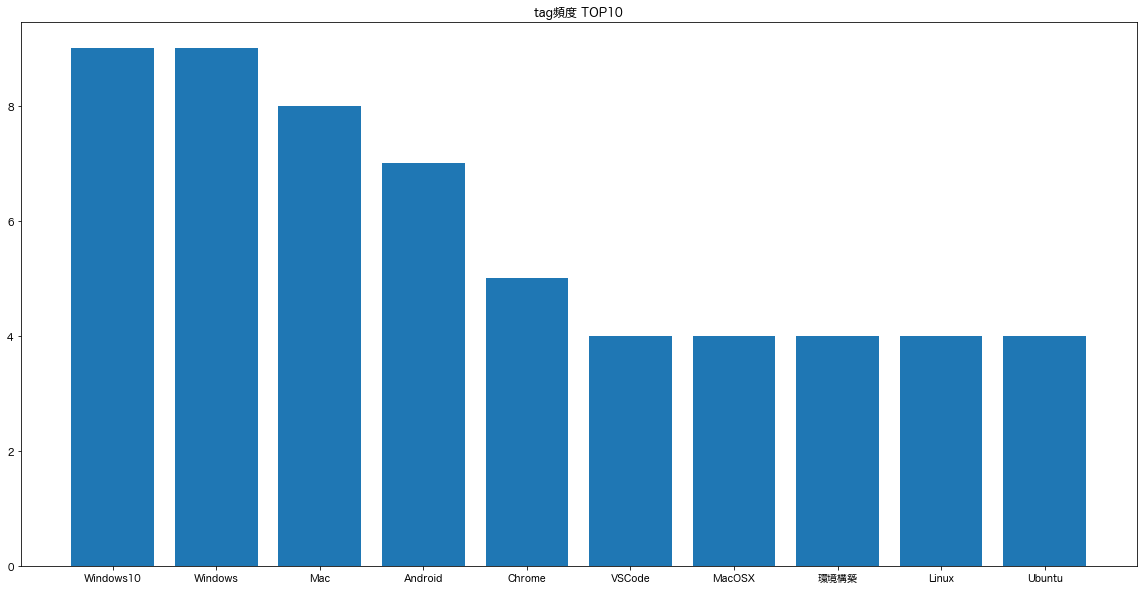

In [111]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from collections import Counter
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']


def check_tag(index):
    c = corpus[index]
    vec_lda = lda[c]
    df_content['tags_str'][index]

    s = doc_index.__getitem__(vec_lda)
    s = sorted(enumerate(s), key=lambda t: t[1], reverse=True)
    
    print(s[:15])
    
    
    frequency = Counter()
    
    for doc_id, sim in s[1:100]:
        tags = df_content['tags_str'][doc_id]
        frequency.update(tags.split(','))
        
    # TOP20のグラフ           
    x = range(10)
    mc = frequency.most_common(10)              # 頻度TOP20を抽出
    ch = [ch[0] for ch in mc]           # ひらがなのリスト
    f = np.array([ch[1] for ch in mc])  # 頻度の数値のリスト


    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(111)

    ax.bar(x, f)
    ax.set_xticks(x)
    ax.set_xticklabels(ch , fontsize=10)  #日本語表示はfontproperties=fp
    ax.set_title("tag頻度 TOP10")

    plt.show()
    
    
check_tag(0)

[(10, 1.0), (2238, 0.8862544), (1554, 0.8853122), (7864, 0.8847274), (7030, 0.88421255), (227, 0.8780832), (3000, 0.87795264), (448, 0.86946887), (562, 0.86072856), (98, 0.85789466), (4701, 0.85664374), (2439, 0.8508081), (1524, 0.84966975), (7601, 0.84682083), (2881, 0.84142065)]


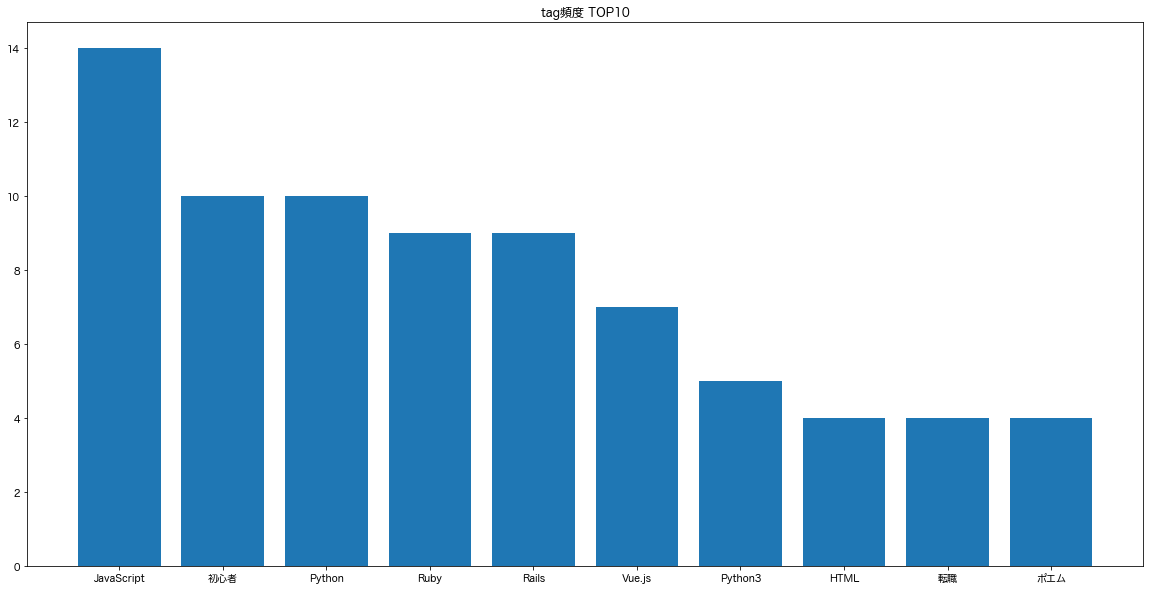

In [112]:
check_tag(10)

[(20, 1.0), (3796, 0.99734604), (3104, 0.9971307), (572, 0.98392177), (8136, 0.9766383), (44, 0.9707874), (784, 0.967509), (4217, 0.9655885), (2602, 0.9653461), (7894, 0.9644503), (1298, 0.964066), (7799, 0.96329075), (811, 0.9615761), (7956, 0.9611647), (2600, 0.95850074)]


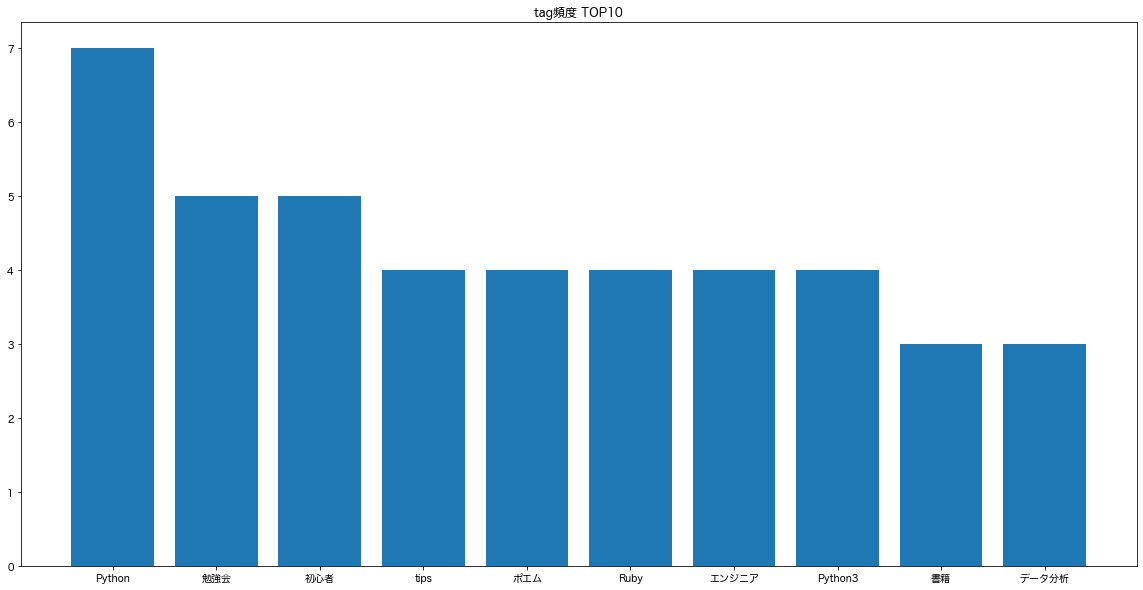

In [116]:
check_tag(20)

[(2, 0.99999946), (3517, 0.78804), (3536, 0.76255757), (101, 0.73011965), (4968, 0.7294658), (3062, 0.72819346), (4142, 0.72775066), (1971, 0.7200485), (4141, 0.71347815), (3259, 0.71169585), (3835, 0.7095678), (7293, 0.6987186), (4, 0.6965829), (5503, 0.6941552), (3519, 0.693528)]


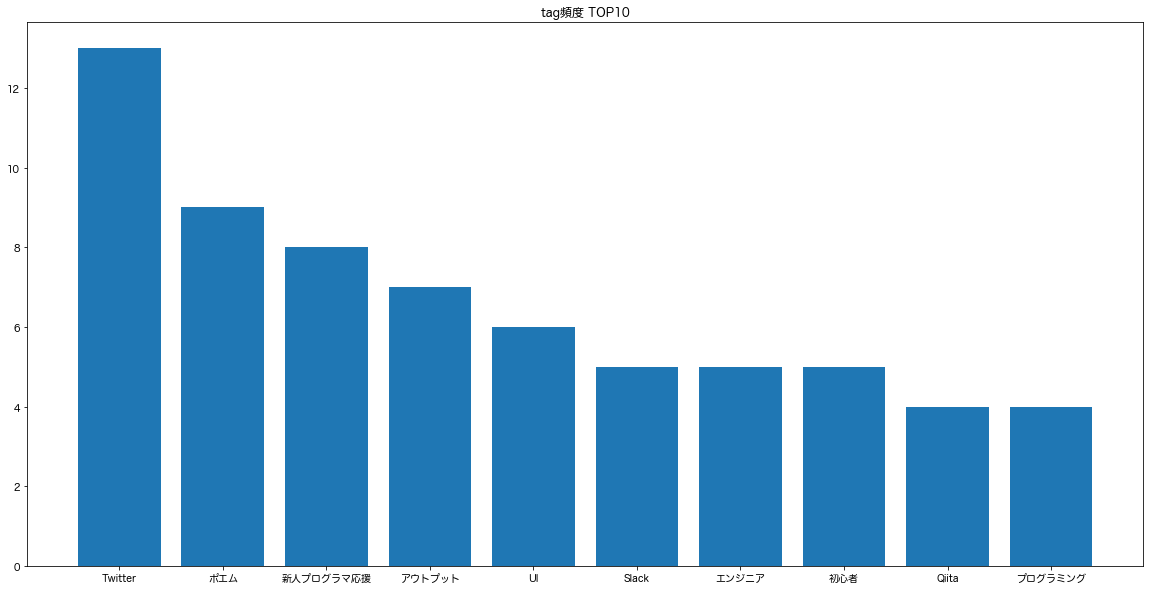

In [117]:
check_tag(2)

# 保存

In [185]:
# d.save_as_text("data/dict.txt")
# corpora.MmCorpus.serialize("data/cop.mm", corpus)
lda5.save("data/lda5.model")
# doc_index.save("data/sim")

saving LdaState object under data/lda5.model.state, separately None
saved data/lda5.model.state
saving LdaModel object under data/lda5.model, separately ['expElogbeta', 'sstats']
storing np array 'expElogbeta' to data/lda5.model.expElogbeta.npy
not storing attribute id2word
not storing attribute dispatcher
not storing attribute state
saved data/lda5.model


In [1]:
from gensim import models, corpora, similarities

corpus = corpora.MmCorpus("data/cop.mm")
lda = models.ldamodel.LdaModel.load("data/lda.model")
d = corpora.Dictionary.load_from_text("data/dict.txt")
doc_index = similarities.docsim.MatrixSimilarity.load("data/sim")

In [2]:
doc_index.__getitem__(lda[corpus[0]])

array([0.99999994, 0.03107498, 0.07525122, ..., 0.03280416, 0.29749227,
       0.05943879], dtype=float32)